# Packages


In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import adfuller


from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro, kstest
from scipy.stats import kendalltau

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [3]:
#import functions_module
from functions_module import remove_season, lissage_moyenne_mobile, logit, import_and_series_transformation, highlight_variables, highlight_result, highlight_value, ljung_box, show_acf_pacf, AugmenteDickeyFuller_test, PhillipsPerron_test, kpss_test

In [3]:
file_path = ""
td = pd.read_excel(file_path+"Bases/default_rate_quarterly.xlsx")
macro = pd.read_excel(file_path+"Bases/variables_macroeconomiques.xlsx")
#base_1 = pd.read_csv(file_path+"Base_1.csv")
#base_2 = pd.read_csv(file_path+"Base_2.csv")

In [4]:
# création du dataframe avec les variables brutes
td = td.set_index("Date")
macro = macro.set_index("Date")
macro["td"]=td
macro.head(3)

,RGDP,HICP,RREP,IRLT,UNR,td
Date,,,,,,
2009-01-31,394004.0,91.3,119.18,4.36,7.589134,NaN
2009-04-30,396296.5,90.6,119.36,4.37,8.103871,NaN
2009-07-31,397582.5,91.8,118.59,4.10,8.280931,NaN


In [22]:
macro.tail(5)

,RGDP,HICP,RREP,IRLT,UNR,td
Date,,,,,,
2019-10-31,382141.9,101.9,99.4,1.27,8.911183,0.027948
2020-01-31,332958.8,104.1,102.4,1.80,8.281296,NaN
2020-04-30,384971.4,103.1,99.8,1.20,11.126750,NaN
2020-07-31,378713.4,103.3,100.0,0.77,9.113091,NaN
2020-10-31,379764.4,102.6,101.1,0.62,9.921993,NaN


In [5]:
# on s'intéresse aux corrélations et tendances en commun entre les variables macro et le taux de défaut. Donc on va retirer les dernières(et premières) observations qui contiennent des valeurs manquantes pour le taux de défaut 
macro.dropna(subset=['td'], how='all', inplace=True)


# Travail de transformation et d'interprétation des séries brutes

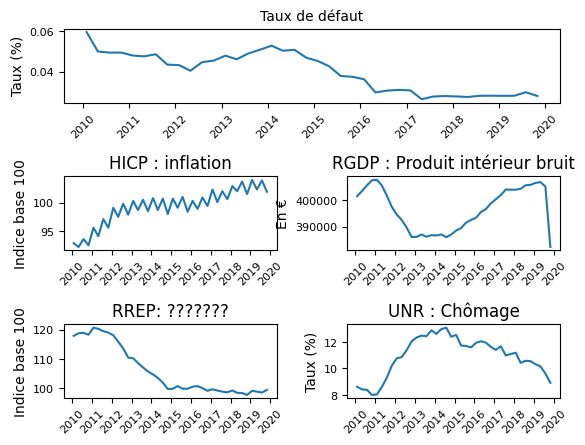

In [6]:
# Create subplots
fig = plt.figure()
ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=6)
ax2 = plt.subplot2grid((3, 6), (1, 0), colspan=3)
ax3 = plt.subplot2grid((3, 6), (1, 3), colspan=3)
ax4 = plt.subplot2grid((3, 6), (2, 0), colspan=3)
ax5 = plt.subplot2grid((3, 6), (2, 3), colspan=3)

# Plot data on each axis
ax1.plot(macro.index, macro['td'])
ax1.set_title('Taux de défaut', fontsize=10)
ax1.set_ylabel('Taux (%)')
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.xaxis.set_tick_params(rotation=45)

ax2.plot(macro.index, macro['HICP'])
ax2.set_title('HICP : inflation')
ax2.set_ylabel('Indice base 100')
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.xaxis.set_tick_params(rotation=45)

ax3.plot(macro.index, macro['RGDP'])
ax3.set_title('RGDP : Produit intérieur brut')
ax3.set_ylabel('En €')
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.xaxis.set_tick_params(rotation=45)

ax4.plot(macro.index, macro['RREP'])
ax4.set_title('RREP: ???????')
ax4.set_ylabel('Indice base 100')
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.xaxis.set_tick_params(rotation=45)

ax5.plot(macro.index, macro['UNR'])
ax5.set_title('UNR : Chômage')
ax5.set_ylabel('Taux (%)')
ax5.tick_params(axis='both', which='major', labelsize=8)
ax5.xaxis.set_tick_params(rotation=45)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=1, wspace=3)

#save plot
plt.savefig('graphs/ts_brutes.png')

# Show the plot
plt.show()


### je retire la saisonnalité de HICP car elle est beaucoup trop présente (voir graphique)


In [7]:
def remove_season(df, list_col):
    """On a vu dans le graphique que des séries peuvent avoir des saisonnalités, alors même que le Taux de défaut n'en a jamais. 
    On voit en particulier le HICP qui a une forte saisonnalité. Celle-ci risque de 
    fausser les résultats pour la suite. On peut choisir de la retirer des saéries
    """
    for col in list_col:
        decomposition = seasonal_decompose(df[col], period=4)
        seasonal = decomposition.seasonal
        df[col] = df[col] - seasonal
    return df
    
    

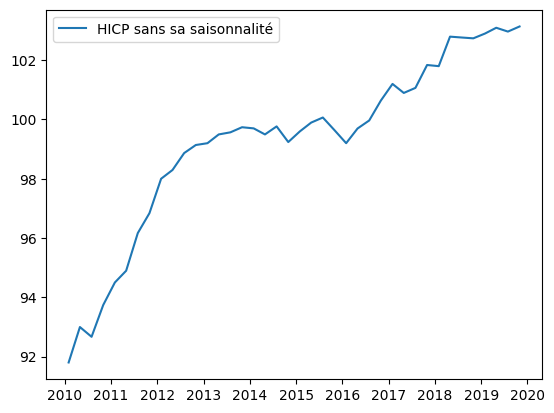

In [8]:
list_col_chosen = ['HICP']

macro = remove_season(macro, list_col_chosen)

for col in list_col_chosen:
    plt.plot(macro.index, macro[col], label=col+" sans sa saisonnalité")
    plt.legend()
    plt.savefig('graphs/ts_no_season_{}.png'.format(col))
    plt.show()


### transformation des séries pour avoir la variation trimestrielle plutôt que de garder la série brute qui ne se prête pas à la modélisation du taux de défaut et aux tests de stationnarité

In [9]:
# Variation trimestrielle
macro[['RGDP_tri', 'HICP_tri', 'IRLT_tri',  'RREP_tri', 'UNR_tri']] = (macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)) / macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)

In [10]:
# Variation annuelle
macro[['RGDP_ann', 'HICP_ann', 'IRLT_ann',  'RREP_ann', 'UNR_ann']] = (macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)) / macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)

In [11]:
col_brutes = ['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']
macro=macro.drop(col_brutes, axis=1)
macro.tail(5)

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2018-10-31,0.028087,0.000413,-0.000270,-0.201729,-0.006104,-0.002660,0.004607,0.008838,0.398990,-0.009128,-0.048633
2019-01-31,0.028018,0.001806,0.001568,-0.054152,0.014330,-0.021933,0.006379,0.010806,0.480226,-0.001008,-0.077956
2019-04-30,0.028056,0.000843,0.001903,-0.370229,-0.003027,-0.016058,0.006489,0.002918,-0.375000,0.004065,-0.026076
2019-07-31,0.029808,-0.004200,-0.001253,-0.393939,-0.003036,-0.052497,-0.001149,0.001946,-0.711816,0.002035,-0.090585
2019-10-31,0.027948,-0.057198,0.001673,0.270000,0.009137,-0.073857,-0.058669,0.003893,-0.541516,0.017400,-0.155505


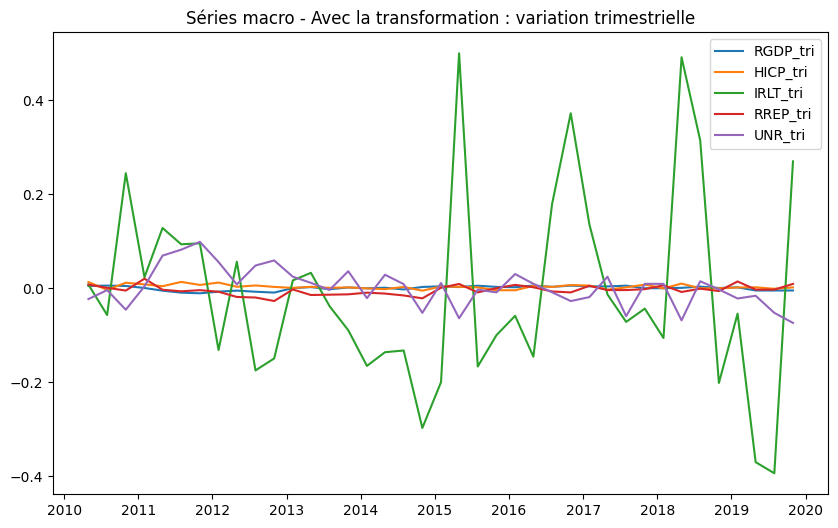

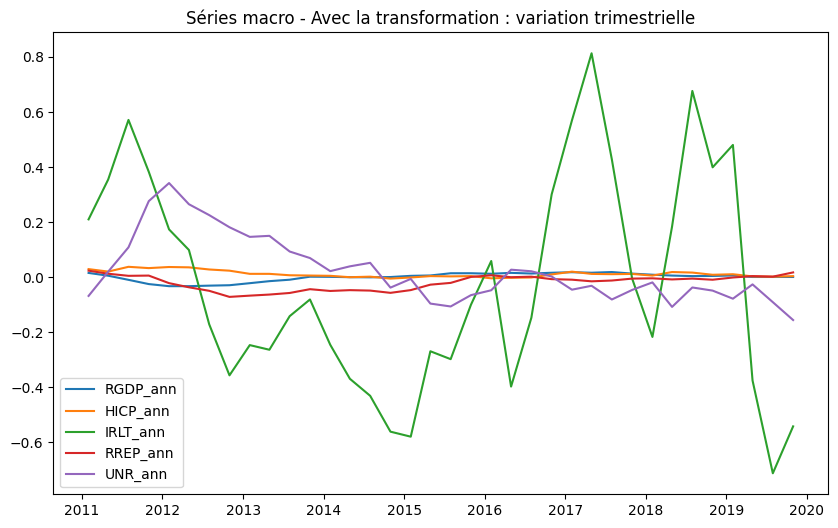

In [42]:
plt.figure(figsize=(10, 6))
for col in macro.filter(regex='tri').columns:
    plt.plot(macro.index, macro[col], label=col)
    plt.legend()
    plt.title("Séries macro - Avec la transformation : variation trimestrielle")
    plt.savefig('graphs/ts_variations.png')
    # plt.show()

plt.figure(figsize=(10, 6))
for col in macro.filter(regex='ann').columns:
    plt.plot(macro.index, macro[col], label=col)
    plt.legend()
    plt.title("Séries macro - Avec la transformation : variation trimestrielle")
    plt.savefig('graphs/ts_variations.png')
    # plt.show()

## Lissage du PIB : la seule variable qui subit un décrochage très fort 

### Les 3 dernières observations sont affectées par le décrochage. Donc je prends les 10 dernières observations et je fais un lissage par moyenne mobile sur les 3 dernières observations en utilisant les 10 dernières observations qui sont représentatives

In [14]:
macro.tail(10)

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2017-07-31,0.027693,0.005365,0.001693,-0.071749,-0.004032,-0.059604,0.018804,0.011004,0.427586,-0.012000,-0.080883
2017-10-31,0.027914,-0.000171,0.007641,-0.043478,-0.002024,0.009295,0.013065,0.011924,-0.005025,-0.005045,-0.046216
2018-01-31,0.027728,0.000043,-0.000382,-0.106061,0.006085,0.009172,0.009073,0.005929,-0.216814,-0.004016,-0.018850
2018-04-30,0.027449,0.000733,0.009782,0.491525,-0.008065,-0.068471,0.005971,0.018831,0.183857,-0.008065,-0.107742
2018-07-31,0.028034,0.003414,-0.000284,0.314394,-0.001016,0.014714,0.004020,0.016821,0.676329,-0.005061,-0.037228
2018-10-31,0.028087,0.000413,-0.000270,-0.201729,-0.006104,-0.002660,0.004607,0.008838,0.398990,-0.009128,-0.048633
2019-01-31,0.028018,0.001806,0.001568,-0.054152,0.014330,-0.021933,0.006379,0.010806,0.480226,-0.001008,-0.077956
2019-04-30,0.028056,0.000843,0.001903,-0.370229,-0.003027,-0.016058,0.006489,0.002918,-0.375000,0.004065,-0.026076
2019-07-31,0.029808,-0.004200,-0.001253,-0.393939,-0.003036,-0.052497,-0.001149,0.001946,-0.711816,0.002035,-0.090585


In [13]:
def lissage_moyenne_mobile(df, list_col, fenetre_des_moyennes, graphiques_Y_N):

    for col in list_col:
        last_observations = df[col].tail(fenetre_des_moyennes)
        last_observations_smoothed = pd.Series(last_observations[-3:].rolling(window=10).mean())
        series_smoothed =  df[col].copy()
        series_smoothed.iloc[-3:] = last_observations_smoothed.fillna(last_observations.mean())

        if graphiques_Y_N == 'Oui':
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(df.index, df[col], label='Original series : '+col)
            ax.plot(df.index, series_smoothed, label='Smoothed series')
            ax.legend(loc='upper left')
            ax.set_xlabel('Date')
            ax.set_ylabel('Values')
            ax.set_title('Smoothed series with last 3 observations replaced by their moving average')
            plt.show()

        df[col] = series_smoothed 

In [41]:
columns = ['RGDP_ann', 'RGDP_tri']
window_size = 10

# lissage_moyenne_mobile(macro, columns, window_size, 'Oui')

In [15]:
macro.tail(10)

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2017-07-31,0.027693,0.005365,0.001693,-0.071749,-0.004032,-0.059604,0.018804,0.011004,0.427586,-0.012000,-0.080883
2017-10-31,0.027914,-0.000171,0.007641,-0.043478,-0.002024,0.009295,0.013065,0.011924,-0.005025,-0.005045,-0.046216
2018-01-31,0.027728,0.000043,-0.000382,-0.106061,0.006085,0.009172,0.009073,0.005929,-0.216814,-0.004016,-0.018850
2018-04-30,0.027449,0.000733,0.009782,0.491525,-0.008065,-0.068471,0.005971,0.018831,0.183857,-0.008065,-0.107742
2018-07-31,0.028034,0.003414,-0.000284,0.314394,-0.001016,0.014714,0.004020,0.016821,0.676329,-0.005061,-0.037228
2018-10-31,0.028087,0.000413,-0.000270,-0.201729,-0.006104,-0.002660,0.004607,0.008838,0.398990,-0.009128,-0.048633
2019-01-31,0.028018,0.001806,0.001568,-0.054152,0.014330,-0.021933,0.006379,0.010806,0.480226,-0.001008,-0.077956
2019-04-30,0.028056,-0.004895,0.001903,-0.370229,-0.003027,-0.016058,0.000859,0.002918,-0.375000,0.004065,-0.026076
2019-07-31,0.029808,-0.004895,-0.001253,-0.393939,-0.003036,-0.052497,0.000859,0.001946,-0.711816,0.002035,-0.090585


### Le lissage exponentiel est particulièrement utile lorsque la série de données contient des points extrêmes qui peuvent affecter la précision de la prévision.

### Pour lisser la série à la fin, on utilise lissage exponentiel avec une constante de lissage plus petite pour donner plus de poids aux observations plus anciennes et moins de poids aux observations plus récentes. Cela peut aider à réduire l'effet des points extrêmes sur la tendance globale de la série de données.

### Il y a des séries qui sont bouleversées par le covid : RGDP, UNR et RREP.  n'est pas impactée par le covid et IRLT est très variable mais autant sur la période covid que la periode sans covid.

### Série du taux de défaut : tranformation logit, ainsi nos prédictions seront toujours dans l'intervalle [0,1]

In [16]:
macro.tail()

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2018-10-31,0.028087,0.000413,-0.000270,-0.201729,-0.006104,-0.002660,0.004607,0.008838,0.398990,-0.009128,-0.048633
2019-01-31,0.028018,0.001806,0.001568,-0.054152,0.014330,-0.021933,0.006379,0.010806,0.480226,-0.001008,-0.077956
2019-04-30,0.028056,-0.004895,0.001903,-0.370229,-0.003027,-0.016058,0.000859,0.002918,-0.375000,0.004065,-0.026076
2019-07-31,0.029808,-0.004895,-0.001253,-0.393939,-0.003036,-0.052497,0.000859,0.001946,-0.711816,0.002035,-0.090585
2019-10-31,0.027948,-0.004895,0.001673,0.270000,0.009137,-0.073857,0.000859,0.003893,-0.541516,0.017400,-0.155505


In [17]:
def logit(p):
    return np.log(p) - np.log(1 - p)


In [18]:
macro['DD'] = macro['td'].apply(logit)
macro['td'] = macro['DD']
macro = macro.drop('DD', axis=1)
macro.tail(10)

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2017-07-31,-3.558478,0.005365,0.001693,-0.071749,-0.004032,-0.059604,0.018804,0.011004,0.427586,-0.012000,-0.080883
2017-10-31,-3.550319,-0.000171,0.007641,-0.043478,-0.002024,0.009295,0.013065,0.011924,-0.005025,-0.005045,-0.046216
2018-01-31,-3.557194,0.000043,-0.000382,-0.106061,0.006085,0.009172,0.009073,0.005929,-0.216814,-0.004016,-0.018850
2018-04-30,-3.567609,0.000733,0.009782,0.491525,-0.008065,-0.068471,0.005971,0.018831,0.183857,-0.008065,-0.107742
2018-07-31,-3.545905,0.003414,-0.000284,0.314394,-0.001016,0.014714,0.004020,0.016821,0.676329,-0.005061,-0.037228
2018-10-31,-3.543942,0.000413,-0.000270,-0.201729,-0.006104,-0.002660,0.004607,0.008838,0.398990,-0.009128,-0.048633
2019-01-31,-3.546488,0.001806,0.001568,-0.054152,0.014330,-0.021933,0.006379,0.010806,0.480226,-0.001008,-0.077956
2019-04-30,-3.545099,-0.004895,0.001903,-0.370229,-0.003027,-0.016058,0.000859,0.002918,-0.375000,0.004065,-0.026076
2019-07-31,-3.482728,-0.004895,-0.001253,-0.393939,-0.003036,-0.052497,0.000859,0.001946,-0.711816,0.002035,-0.090585


### Séries brutes transformées

### Conclusion sur les varaibles macro : 
La variable a un sens eco ? 

RGPD_tri = oui

HICP = je pense

IRLT = pas trop vu que si taux augmentent alors on devrait avoir plus de défauts

URN = oui

RGDP_ann = oui totalement

HICP = je pense

IRLT = meme probleme ann que tri

RREP = oui

UNR = oui 



macro_ADL = macro.copy() # le dataframe utilisé pour la modélisation

macro = macro.dropna()# drop les nan pour pouvoir faire les tests de stationnarité...

### Pipeline finale pour obternir un dataframe avec les transformations voulues

In [3]:
"""
variables qu'on peut changer dans le code :
    - on peut retirer la saisonnalité d'autres variables que seulement HICP
    - on peut lisser par moyenne mobile sur les dernières valeurs pour plus de variables
    - on peut appliquer la transformation logit ou pas
"""

def import_and_series_transformation(drop_na, list_col_saison, list_col_lissage, logit_choix) :

    """
    drop_na : retirer les lignes avec des valeurs manquantes dans la colonne du taux de défaut
    list_col_chosen : les variables pour lesquelles on souhaite estimer puis retirer la saisonnalité
    list_col_lissage : lissage des dernieres observation des variables, par la moyenne mobile
    logit : application oui ou non de la transformation Logit sur le taux de défaut

    """

    # importation des données
    td = pd.read_excel("Bases/default_rate_quarterly.xlsx")
    macro = pd.read_excel("Bases/variables_macroeconomiques.xlsx")

    # création du dataframe, avec les variables macro et le TD, index par la date
    td = td.set_index("Date")
    macro = macro.set_index("Date")
    macro["td"]=td


    # drop les valeurs manquantes (selon la colonne du TD)
    if drop_na == 'Oui':
        macro.dropna(subset=['td'], how='all', inplace=True)

    # retirons la saisonnalités des variables choisies
    macro = remove_season(macro, list_col_saison)

        
    # Variation trimestrielle
    macro[['RGDP_tri', 'HICP_tri', 'IRLT_tri',  'RREP_tri', 'UNR_tri']] = (macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)) / macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(1)
    # Variation annuelle
    macro[['RGDP_ann', 'HICP_ann', 'IRLT_ann',  'RREP_ann', 'UNR_ann']] = (macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']] - macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)) / macro[['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']].shift(4)

        
    # retirons les variables brutes
    col_brutes = ['RGDP', 'HICP', 'IRLT',  'RREP', 'UNR']
    macro=macro.drop(col_brutes, axis=1)

    # Lissage par moyenne mobile des variables indiquées dans la liste 'columns'
    window_size = 10
    lissage_moyenne_mobile(macro, list_col_lissage, window_size, 'N')

    # appliquer le logit sur le taux de défaut ou pas
    if logit_choix == 'Oui':
        macro['DD'] = macro['td'].apply(logit)
        macro['td'] = macro['DD']
        macro = macro.drop('DD', axis=1)
        
    return macro

In [4]:
drop_na = 'Non'
list_col_saison = ['HICP']
list_col_lissage = ['RGDP_ann', 'RGDP_tri']
logit_choix = 'Non'
types_var_choix = 'trimestrielle' # sinon {'trimestrielle', 'annuelle'}

macro = import_and_series_transformation(drop_na, list_col_saison, list_col_lissage, logit_choix)
macro

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,0.005818,0.011609,0.002294,0.001510,0.067826,NaN,NaN,NaN,NaN,NaN
2009-07-31,NaN,0.003245,-0.004170,-0.061785,-0.006451,0.021849,NaN,NaN,NaN,NaN,NaN
2009-10-31,NaN,0.002682,0.011061,-0.004878,-0.015094,0.026107,NaN,NaN,NaN,NaN,NaN
2010-01-31,0.059661,0.007475,-0.000791,-0.019608,0.009418,0.013578,0.019352,0.017728,-0.082569,-0.010740,0.134846
2010-04-30,0.049995,0.004781,0.011407,0.007500,0.007634,-0.023120,0.018300,0.017524,-0.077803,-0.004692,0.038192
2010-07-31,0.049434,0.005487,-0.001945,-0.057072,0.000842,-0.004081,0.020576,0.019798,-0.073171,0.002614,0.011847
2010-10-31,0.049466,0.004767,0.010846,0.244737,-0.005046,-0.045791,0.022698,0.019581,0.159314,0.012842,-0.059051
2011-01-31,0.047990,0.000450,0.008827,0.023256,0.020287,0.004039,0.015567,0.029395,0.210000,0.023749,-0.067907


In [5]:
def drop_trimestrielle_or_annuelle_if_wanted(df, choix) :
    """
    What kind of variables do you wish to keep :
    choix = {'both', 'trimestrielle', 'annuelle'}"""

    if choix == 'trimestrielle':
        df = df.filter(regex='^(td|.*_tri)$')
    elif choix == 'annuelle':
        df = df.filter(regex='^(td|.*_ann)$')
    else :
        pass
    return df

In [6]:
macro = drop_trimestrielle_or_annuelle_if_wanted(macro, 'toutes')
macro

,td,RGDP_tri,HICP_tri,IRLT_tri,RREP_tri,UNR_tri,RGDP_ann,HICP_ann,IRLT_ann,RREP_ann,UNR_ann
Date,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,0.005818,0.011609,0.002294,0.001510,0.067826,NaN,NaN,NaN,NaN,NaN
2009-07-31,NaN,0.003245,-0.004170,-0.061785,-0.006451,0.021849,NaN,NaN,NaN,NaN,NaN
2009-10-31,NaN,0.002682,0.011061,-0.004878,-0.015094,0.026107,NaN,NaN,NaN,NaN,NaN
2010-01-31,0.059661,0.007475,-0.000791,-0.019608,0.009418,0.013578,0.019352,0.017728,-0.082569,-0.010740,0.134846
2010-04-30,0.049995,0.004781,0.011407,0.007500,0.007634,-0.023120,0.018300,0.017524,-0.077803,-0.004692,0.038192
2010-07-31,0.049434,0.005487,-0.001945,-0.057072,0.000842,-0.004081,0.020576,0.019798,-0.073171,0.002614,0.011847
2010-10-31,0.049466,0.004767,0.010846,0.244737,-0.005046,-0.045791,0.022698,0.019581,0.159314,0.012842,-0.059051
2011-01-31,0.047990,0.000450,0.008827,0.023256,0.020287,0.004039,0.015567,0.029395,0.210000,0.023749,-0.067907


# **Analyses PACF et ACF**



En input on prend le dataframe "macro". Attention, il y a encore le taux de défaut, on veut le drop

Pour avoir une première idée sur la stationnarité des variables, on trace des autocorrélogrames.

Les résultats nous disent que : 

RGDP : 
HICP : 
IRLT : 
RREP : 
UNR : 


df = macro.copy()
for col in df.drop('td', axis=1).columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

        # plot ACF on the left subplot
        plot_acf(df.dropna()[col], lags=8, ax=axs[0])
        axs[0].set_title("ACF of " + col)

        # plot PACF on the right subplot
        plot_pacf(df.dropna()[col], lags=8, ax=axs[1])
        axs[1].set_title("PACF of " + col)

        # show the plot for each variable
        plt.show()

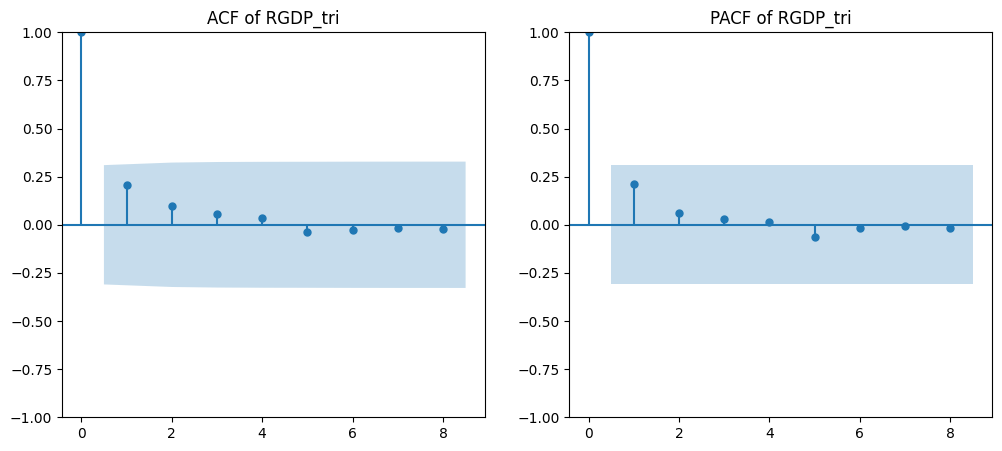

In [18]:
def show_acf_pacf(df, variable):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # plot ACF on the left subplot
    plot_acf(df.dropna()[variable], lags=8, ax=axs[0])
    axs[0].set_title("ACF of " + variable)

    # plot PACF on the right subplot
    plot_pacf(df.dropna()[variable], lags=8, ax=axs[1])
    axs[1].set_title("PACF of " + variable)

    # show the plot for each variable
    plt.show()
show_acf_pacf(macro, 'RGDP_tri')

**Seul le PIB a l'air presque stationnaire. Mais sinon on détecte des AR(1) souvent**

**Tests de stationnarité** *KPSS and Philips Perron*

# ***Les tests***

**Ljung-Box Test**

We could use to pvalues : Ljung-Box and Box-Pierce. But Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is has better finite-sample properties. Ljung-Box is best in our case

macro_Box = macro.drop('td', axis=1).dropna()
results = pd.DataFrame(columns=['Variable', 'Ljung-Box Statistic', 'p-value','Result'])
for col in macro.drop('td', axis=1):
    i=macro_Box[col]
    res = sm.tsa.ARIMA(i, order=(1,0,1)).fit()
    print(sm.stats.acorr_ljungbox(res.resid, lags=[5]))
    results.loc[len(results)] = [col, sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 0], sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 1], sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 1] < 0.05]
    results['Result'] = results['Result'].replace(False, 'Residuals are NOT independant')
    results['Result'] = results['Result'].replace(True, 'Residuals are independant')
results

  #if True then it means the serie has residuals that are correlated

In [40]:
def ljung_box(df):
    macro_Box = df.drop('td', axis=1).dropna()
    results = pd.DataFrame(columns=['Variable', 'Ljung-Box Statistic', 'p-value','Result'])
    for col in df.drop('td', axis=1):
        res = sm.tsa.ARIMA(macro_Box[col], order=(1,0,1)).fit()
        # print(sm.stats.acorr_ljungbox(res.resid, lags=[5]))
        results.loc[len(results)] = [col, sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 0], sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 1], sm.stats.acorr_ljungbox(res.resid, lags=[5]).iloc[0, 1] < 0.05]
    results['Result'] = results['Result'].replace(False, 'Residuals are NOT independant')
    results['Result'] = results['Result'].replace(True, 'Residuals are independant')
    
    return results

    #if True then it means the serie has residuals that are correlated


results_Ljung_box = ljung_box(macro)
results_Ljung_box.style.applymap(highlight_value, subset=['Result'])

,Variable,Ljung-Box Statistic,p-value,Result
0,RGDP_tri,0.037419,0.999986,Residuals are NOT independant
1,HICP_tri,12.404887,0.029642,Residuals are independant
2,IRLT_tri,2.470383,0.780949,Residuals are NOT independant
3,RREP_tri,11.092339,0.049580,Residuals are independant
4,UNR_tri,0.400435,0.995318,Residuals are NOT independant
5,RGDP_ann,0.370254,0.996109,Residuals are NOT independant
6,HICP_ann,7.020063,0.219152,Residuals are NOT independant
7,IRLT_ann,5.291310,0.381372,Residuals are NOT independant
8,RREP_ann,11.146938,0.048543,Residuals are independant
9,UNR_ann,4.347762,0.500507,Residuals are NOT independant


***KPSS*** 

Taking the null hypothesis as a stationary process and the unit
root as an alternative is in accordance with a conservative testing strategy. If we then reject the null hypothesis, we can
be pretty confident that the series indeed has a unit root. (Plaff, 2008)

In [11]:
def kpss_test(df, regression, alpha='5%'):
    # Initialisation du DataFrame de résultats
    results = pd.DataFrame(columns=['Test', 'Variable', 'Regression', 'Test Statistic', 'p-value', 'Lags Used', 'Résultat'])

    # Boucle sur chaque colonne de la DataFrame
    for col in df.columns:
        # Calcul du test KPSS pour la série temporelle
        kpss_result = kpss(df[col], regression=regression)
        
        # Ajout des résultats du test ADF dans le DataFrame de résultats
        results.loc[len(results)] = ['KPSS', col, regression, round(kpss_result[0], 3), round(kpss_result[1], 3), kpss_result[2], kpss_result[0] < kpss_result[3][alpha]]
    
    # Remplacement des valeurs booléennes par des chaînes de caractères lisibles
    results['Résultat'] = results['Résultat'].replace(False, 'Not Stationary')
    results['Résultat'] = results['Résultat'].replace(True, 'Stationary')

    return results


In [12]:
# fixons les types de regressions qu'on veut tester pendant la stationnarité
regression_type = 'c' # peut être {'c', 'ct', 'c_et_ct'} 



if regression_type == 'c':
    results_kpss = kpss_test(macro.drop('td', axis=1).dropna(), regression='c')
elif regression_type == 'ct':
    results_kpss = kpss_test(macro.drop('td', axis=1).dropna(), regression='ct')
else : # 'c_et_ct'
    results_c = kpss_test(macro.drop('td', axis=1).dropna(), regression='c')
    results_ct = kpss_test(macro.drop('td', axis=1).dropna(), regression='ct')
    results_kpss = pd.concat([results_c, results_ct], ignore_index=True)



results_kpss

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
0,KPSS,RGDP_tri,c,0.269,0.100,2,Stationary
1,KPSS,HICP_tri,c,0.353,0.098,3,Stationary
2,KPSS,IRLT_tri,c,0.099,0.100,3,Stationary
3,KPSS,RREP_tri,c,0.371,0.090,2,Stationary
4,KPSS,UNR_tri,c,0.164,0.100,0,Stationary
5,KPSS,RGDP_ann,c,0.208,0.100,3,Stationary
6,KPSS,HICP_ann,c,0.445,0.058,4,Stationary
7,KPSS,IRLT_ann,c,0.108,0.100,3,Stationary
8,KPSS,RREP_ann,c,0.294,0.100,4,Stationary
9,KPSS,UNR_ann,c,0.483,0.045,4,Not Stationary


***PP***
 
rappel : H0: The time series has a unit root (is non-stationary)



In [13]:
def PhillipsPerron_test(df,regression, alpha='5%'):
    # Initialisation du DataFrame de résultats
    results = pd.DataFrame(columns=['Test' ,'Variable', 'Regression', 'Test Statistic', 'p-value', 'Lags Used', 'Résultat'])

    # Boucle sur chaque colonne de la DataFrame
    for col in df.columns:
        # Calcul du test ADF pour la série temporelle
        pp_result = PhillipsPerron(df[col], trend=regression)
        # Ajout des résultats du test ADF dans le DataFrame de résultats
        results.loc[col] = ['PP', col, regression, round(pp_result.stat, 3), round(pp_result.pvalue, 3) , pp_result.lags, pp_result.pvalue < 0.05]
    
    # Remplacement des valeurs booléennes par des chaînes de caractères lisibles
    results['Résultat'] = results['Résultat'].replace(False, 'Not Stationary')
    results['Résultat'] = results['Résultat'].replace(True, 'Stationary')

    return results


In [14]:
macro_pp = macro.drop('td', axis=1).dropna() 
# fixons les types de regressions qu'on veut tester pendant la stationnarité
regression_type = 'n' # peut être {'n', 'c', 'ct', 'n_et_c', 'n_et_ct', 'c_et_ct', 'all'} 



if regression_type == 'n':
    results_pp = PhillipsPerron_test(macro_pp, regression='n')
elif regression_type == 'c':
    results_pp = PhillipsPerron_test(macro_pp, regression='c')
elif regression_type == 'ct':
    results_pp = PhillipsPerron_test(macro_pp, regression='ct')
elif regression_type == 'n_et_c':
    results_n = PhillipsPerron_test(macro_pp, regression='n')
    results_c = PhillipsPerron_test(macro_pp, regression='c')
    results_pp = pd.concat([results_n, results_c], ignore_index=True)
elif regression_type == 'n_et_ct':
    results_n = PhillipsPerron_test(macro_pp, regression='n')
    results_ct = PhillipsPerron_test(macro_pp, regression='ct')
    results_pp = pd.concat([results_n, results_ct], ignore_index=True)
elif regression_type == 'c_et_ct':
    results_c = PhillipsPerron_test(macro_pp, regression='c')
    results_ct = PhillipsPerron_test(macro_pp, regression='ct')
    results_pp = pd.concat([results_c, results_ct], ignore_index=True)
else:
    results_n = PhillipsPerron_test(macro_pp, regression='n')
    results_c = PhillipsPerron_test(macro_pp, regression='c')
    results_ct = PhillipsPerron_test(macro_pp, regression='ct')
    results_pp = pd.concat([results_n, results_c, results_ct], ignore_index=True)
    
    
results_pp

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
RGDP_tri,PP,RGDP_tri,n,-4.035,0.000,10,Stationary
HICP_tri,PP,HICP_tri,n,-7.429,0.000,10,Stationary
IRLT_tri,PP,IRLT_tri,n,-5.183,0.000,10,Stationary
RREP_tri,PP,RREP_tri,n,-5.863,0.000,10,Stationary
UNR_tri,PP,UNR_tri,n,-8.626,0.000,10,Stationary
RGDP_ann,PP,RGDP_ann,n,-3.291,0.001,10,Stationary
HICP_ann,PP,HICP_ann,n,-1.445,0.139,10,Not Stationary
IRLT_ann,PP,IRLT_ann,n,-2.257,0.023,10,Stationary
RREP_ann,PP,RREP_ann,n,-1.383,0.155,10,Not Stationary
UNR_ann,PP,UNR_ann,n,-2.363,0.017,10,Stationary


***ADF***

In [15]:
def AugmenteDickeyFuller_test(df,regression, alpha='5%'):
    # Initialisation du DataFrame de résultats
    results = pd.DataFrame(columns=['Test', 'Variable', 'Regression', 'Test Statistic', 'p-value', 'Lags Used', 'Résultat'])

    # Boucle sur chaque colonne de la DataFrame
    for col in df.columns:
        # Calcul du test ADF pour la série temporelle
        adf_result = adfuller(df[col], regression=regression)
        # Ajout des résultats du test ADF dans le DataFrame de résultats
        results.loc[col] = ['ADF', col, regression, round(adf_result[0], 3), round(adf_result[1], 3) , adf_result[2], adf_result[1] < 0.05]
    
    # Remplacement des valeurs booléennes par des chaînes de caractères lisibles
    results['Résultat'] = results['Résultat'].replace(False, 'Not Stationary')
    results['Résultat'] = results['Résultat'].replace(True, 'Stationary')

    return results


In [19]:
macro_pp = macro.drop('td', axis=1).dropna() 
# fixons les types de regressions qu'on veut tester pendant la stationnarité
regression_type = 'n' # peut être {'n', 'c', 'ct', 'n_et_c', 'n_et_ct', 'c_et_ct', 'all'} 



if regression_type == 'all':
    results_adf = AugmenteDickeyFuller_test(macro_pp, regression='n')
elif regression_type == 'c':
    results_adf = AugmenteDickeyFuller_test(macro_pp, regression='c')
elif regression_type == 'ct':
    results_adf = AugmenteDickeyFuller_test(macro_pp, regression='ct')
elif regression_type == 'n_et_c':
    results_n = AugmenteDickeyFuller_test(macro_pp, regression='n')
    results_c = AugmenteDickeyFuller_test(macro_pp, regression='c')
    results_adf = pd.concat([results_n, results_c], ignore_index=True)
elif regression_type == 'n_et_ct':
    results_n = AugmenteDickeyFuller_test(macro_pp, regression='n')
    results_ct = AugmenteDickeyFuller_test(macro_pp, regression='ct')
    results_adf = pd.concat([results_n, results_ct], ignore_index=True)
elif regression_type == 'c_et_ct':
    results_c = AugmenteDickeyFuller_test(macro_pp, regression='c')
    results_ct = AugmenteDickeyFuller_test(macro_pp, regression='ct')
    results_adf = pd.concat([results_c, results_ct], ignore_index=True)
else:
    results_n = AugmenteDickeyFuller_test(macro_pp, regression='n')
    results_c = AugmenteDickeyFuller_test(macro_pp, regression='c')
    results_ct = AugmenteDickeyFuller_test(macro_pp, regression='ct')
    results_adf = pd.concat([results_n, results_c, results_ct], ignore_index=True)
    
    
results_adf

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
0,ADF,RGDP_tri,n,-4.131,0.000,0,Stationary
1,ADF,HICP_tri,n,-2.462,0.013,1,Stationary
2,ADF,IRLT_tri,n,-2.738,0.006,10,Stationary
3,ADF,RREP_tri,n,-0.995,0.290,7,Not Stationary
4,ADF,UNR_tri,n,-9.007,0.000,0,Stationary
5,ADF,RGDP_ann,n,-3.267,0.001,0,Stationary
6,ADF,HICP_ann,n,-2.466,0.013,9,Stationary
7,ADF,IRLT_ann,n,-2.944,0.003,10,Stationary
8,ADF,RREP_ann,n,-1.193,0.213,4,Not Stationary
9,ADF,UNR_ann,n,-1.845,0.062,1,Not Stationary


## ***Tous les tests***

In [ ]:
def concat_tests_and_sort (kpss, pp, adf):
    results_of_tests = pd.concat([kpss, pp, adf], ignore_index=True)
    results_of_tests = results_of_tests.drop('Test Statistic', axis=1)
    results_of_tests = results_of_tests.sort_values(['Variable', 'Regression'], ascending=[True, False])
    return results_of_tests



In [54]:
# Input à définir : 
"""nb_variables_studies = len(results_all_tests['Variable'].unique()) """# toujours 10 sauf si on choisit de retirer les variables _ann ou _tri
"""macro_pp""" # = macro.drop('td', axis=1).dropna() à définir avant : pour les 3 tests.
resultats_des_tests = concat_tests_and_sort(results_kpss, results_pp, results_adf)
resultats_des_tests

nb_variables_studies = len(resultats_des_tests['Variable'].unique())



,Test,Variable,Regression,p-value,Lags Used,Résultat
16,PP,HICP_ann,n,0.139,10,Not Stationary
26,ADF,HICP_ann,n,0.013,9,Stationary
46,ADF,HICP_ann,ct,0.045,7,Stationary
6,KPSS,HICP_ann,c,0.058,4,Stationary
36,ADF,HICP_ann,c,0.009,7,Stationary
11,PP,HICP_tri,n,0.000,10,Stationary
21,ADF,HICP_tri,n,0.013,1,Stationary
41,ADF,HICP_tri,ct,0.000,0,Stationary
1,KPSS,HICP_tri,c,0.098,3,Stationary
31,ADF,HICP_tri,c,0.000,0,Stationary


In [55]:
def draw_conclusion_stationary(results_all_tests, nb_variables_studies):

    # Group the dataframe by 'Variable' and 'Résultat', then get the size of each group
    result_counts = results_all_tests.groupby(['Variable', 'Résultat']).size().reset_index(name='Count')

    # Filter the groups where 'Résultat' is 'Stationary'
    result_counts = result_counts[result_counts['Résultat'] == 'Stationary']

    # Drop the 'Résultat' column from the result_counts dataframe
    result_counts = result_counts.drop('Résultat', axis=1)


    # Rename the 'Count' column to 'Stationary_count'
    result_counts = result_counts.rename(columns={'Count': 'Stationary_count'})

    # Merge the result_counts dataframe with the original results_all_tests dataframe
    results_all_tests = results_all_tests.merge(result_counts, on='Variable', how='left')

    # Group the dataframe by 'Variable', then get the count of rows for each group
    row_counts = results_all_tests.groupby('Variable').size()

    # Divide the 'Stationary_count' column by the row counts for each variable
    results_all_tests['Stationary_ratio'] = results_all_tests['Stationary_count'] / (len(results_all_tests)/nb_variables_studies)

    # Fill NaN values with 0
    results_all_tests['Stationary_ratio'] = results_all_tests['Stationary_ratio'].fillna(0)

    results_all_tests['Proportion de conclusion positive pour la stationnarité (%)'] = (round(results_all_tests['Stationary_ratio'], 4) * 100)

    # decision finale sur la stationnarité de la variable
    results_all_tests.loc[results_all_tests['Proportion de conclusion positive pour la stationnarité (%)']>50, 'Décision Finale'] = 'Stationnaire'
    results_all_tests.loc[results_all_tests['Proportion de conclusion positive pour la stationnarité (%)']<=50, 'Décision Finale'] = 'Non Stationnaire'

    return results_all_tests

conclusions = draw_conclusion_stationary(resultats_des_tests, nb_variables_studies)
conclusions

,Test,Variable,Regression,p-value,Lags Used,Résultat,Stationary_count,Stationary_ratio,Proportion de conclusion positive pour la stationnarité (%),Décision Finale
0,PP,HICP_ann,n,0.139,10,Not Stationary,4,0.8,80.0,Stationnaire
1,ADF,HICP_ann,n,0.013,9,Stationary,4,0.8,80.0,Stationnaire
2,ADF,HICP_ann,ct,0.045,7,Stationary,4,0.8,80.0,Stationnaire
3,KPSS,HICP_ann,c,0.058,4,Stationary,4,0.8,80.0,Stationnaire
4,ADF,HICP_ann,c,0.009,7,Stationary,4,0.8,80.0,Stationnaire
5,PP,HICP_tri,n,0.000,10,Stationary,5,1.0,100.0,Stationnaire
6,ADF,HICP_tri,n,0.013,1,Stationary,5,1.0,100.0,Stationnaire
7,ADF,HICP_tri,ct,0.000,0,Stationary,5,1.0,100.0,Stationnaire
8,KPSS,HICP_tri,c,0.098,3,Stationary,5,1.0,100.0,Stationnaire
9,ADF,HICP_tri,c,0.000,0,Stationary,5,1.0,100.0,Stationnaire


In [56]:
def readable_conclusions(results_all_tests):
    
    # Drop non useful columns
    col_drop = ['Test','p-value', 'Regression','Regression', 'Lags Used', 'Résultat', 'Stationary_count','Stationary_ratio']
    results_all_tests = results_all_tests.drop(col_drop, axis=1)

    # Drop duplicate rows
    results_all_tests = results_all_tests.drop_duplicates()

    # Reset the index
    results_all_tests = results_all_tests.reset_index(drop=True)


    return results_all_tests

conclusions_readable = readable_conclusions(conclusions)
conclusions_readable

,Variable,Proportion de conclusion positive pour la stationnarité (%),Décision Finale
0,HICP_ann,80.0,Stationnaire
1,HICP_tri,100.0,Stationnaire
2,IRLT_ann,80.0,Stationnaire
3,IRLT_tri,80.0,Stationnaire
4,RGDP_ann,100.0,Stationnaire
5,RGDP_tri,100.0,Stationnaire
6,RREP_ann,40.0,Non Stationnaire
7,RREP_tri,60.0,Stationnaire
8,UNR_ann,20.0,Non Stationnaire
9,UNR_tri,100.0,Stationnaire


In [58]:
# Apply colors style on last column to column all tests
conclusions_readable.style.applymap(highlight_result, subset=['Décision Finale'])


,Variable,Proportion de conclusion positive pour la stationnarité (%),Décision Finale
0,HICP_ann,80.000000,Stationnaire
1,HICP_tri,100.000000,Stationnaire
2,IRLT_ann,80.000000,Stationnaire
3,IRLT_tri,80.000000,Stationnaire
4,RGDP_ann,100.000000,Stationnaire
5,RGDP_tri,100.000000,Stationnaire
6,RREP_ann,40.000000,Non Stationnaire
7,RREP_tri,60.000000,Stationnaire
8,UNR_ann,20.000000,Non Stationnaire
9,UNR_tri,100.000000,Stationnaire


In [ ]:
conclusions_readable[conclusions_readable['Décision Finale']=='Stationnaire']['Variable'].unique()

In [ ]:

def highlight_variables(row):
    if row['Variable'] == 'HICP_ann':
        return ['background-color: linen']*len(row)
    if row['Variable'] == 'HICP_tri':
        return ['background-color: peru']*len(row)
    if row['Variable'] == 'IRLT_ann':
        return ['background-color: seashell']*len(row)
    if row['Variable'] == 'IRLT_tri':
        return ['background-color: palegreen']*len(row)
    if row['Variable'] == 'RGDP_ann':
        return ['background-color: azure']*len(row)
    if row['Variable'] == 'RGDP_tri':
        return ['background-color: lightblue']*len(row)
    if row['Variable'] == 'RREP_ann':
        return ['background-color: lavender']*len(row)
    if row['Variable'] == 'RREP_tri':
        return ['background-color: thistle']*len(row)
    if row['Variable'] == 'UNR_ann':
        return ['background-color: lavenderbush']*len(row)
    if row['Variable'] == 'UNR_tri':
        return ['background-color: lightpink']*len(row)
    else:
        return ['background-color: chocolate']*len(row)

    
def highlight_result(val):
    if val == 'Stationnaire':
        return 'color: white; background-color: mediumspringgreen'
    else:
        return 'color: white; background-color: peachpuff'


# On doit pouvoir choisir a la main sur streamlit les variables qu'on garde pour la suite

In [7]:
Variables_stationnaires = ['HICP_ann', 'HICP_tri', 'IRLT_ann', 'IRLT_tri', 'RGDP_ann', 'RGDP_tri', 'RREP_tri', 'UNR_tri']

# Stationnarité du taux de defaut 

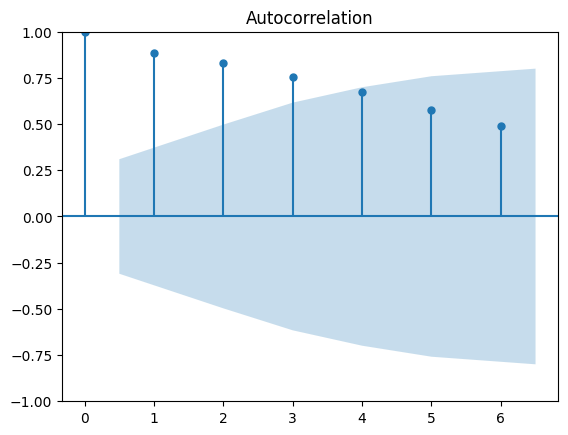

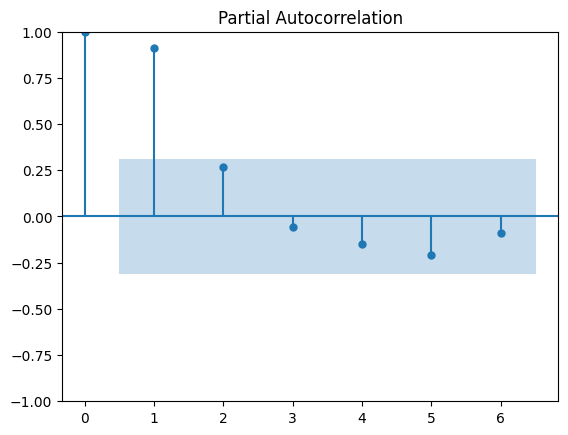

In [75]:
td_serie = pd.DataFrame(macro['td']).dropna()
plot_acf(td_serie, lags=6)
plot_pacf(td_serie, lags=6)  
plt.show()

In [76]:
results_KPSS_c = kpss_test(td_serie, regression='c')
results_ct = kpss_test(td_serie, regression='ct')

results_kpss = pd.concat([results_KPSS_c, results_ct], ignore_index=True)

In [77]:
results_n = PhillipsPerron_test(td_serie,  regression='n')
results_PP_c = PhillipsPerron_test(td_serie, regression='c')
results_ct = PhillipsPerron_test(td_serie, regression='ct')

results_pp = pd.concat([results_n, results_PP_c, results_ct], ignore_index=True)

In [78]:
results_n = AugmenteDickeyFuller_test(td_serie, regression='n')
results_ADF_c = AugmenteDickeyFuller_test(td_serie, regression='c')
results_ct = AugmenteDickeyFuller_test(td_serie, regression='ct')

results_adf = pd.concat([results_n, results_ADF_c, results_ct], ignore_index=True)

In [79]:
results_DR = pd.concat([results_KPSS_c, results_PP_c, results_ADF_c], ignore_index=True)
results_DR

,Test,Variable,Regression,Test Statistic,p-value,Lags Used,Résultat
0,KPSS,td,c,0.765,0.010,4,Not Stationary
1,PP,td,c,-1.741,0.410,10,Not Stationary
2,ADF,td,c,-1.700,0.431,0,Not Stationary


## Taux de défaut n'est pas stationnaire sans lui apporter aucune transformation

In [80]:
#macro_dropna = macro.dropna()

# ***Stationnarisation du Taux de défaut par différence partielle FAUT FAIRE UNE PIPELINE AVEC LES TESTS***

In [16]:
def newey_west_tests_find_beta(dataframe, test):
    """On doit faire le test de Newey-West, en utilisant la série DRt - Beta*DRt-1. On passe par les tests KPSS, PP et ADF """
    
    #creation du dataframe qu'on utilisera à chaque fois
    df = pd.DataFrame()
    df['td'] = dataframe['td']
    df['td_minus1']=df['td'].shift(1)
    df = df.dropna()
    
    # create an empty DataFrame for the results with columns for betax, stat, crit, and regression type
    df_results = pd.DataFrame(columns=['betax', 'stat', 'crit', 'regression type']) 
    fig, ax = plt.subplots()
    betax = []
    pvalues = []
    crit = []
    stat = []

    for beta in range(100):
        df['DRt_beta'] = df['td'] - (beta/100)*df['td_minus1'] #creation de la série qu'on va utiliser pour mener le test
        
        if test == 'KPSS':
            reg = 'c'
            kpss_result = kpss(df["DRt_beta"], regression=reg)
            stat.append(kpss_result[0])
            pvalues.append(kpss_result[1])
            crit.append(kpss_result[3]['5%']) # récupérer la valeur critique
        elif test == 'PP':
            reg = 'c'
            pp_result = PhillipsPerron(df['DRt_beta'], trend=reg)
            stat.append(pp_result.stat)
            pvalues.append(pp_result.pvalue)
            crit.append(pp_result.critical_values['5%']) # récupérer la valeur critique
        else:
            reg = 'c'
            adf_result = adfuller(df['DRt_beta'], regression=reg)
            stat.append(adf_result[0])
            pvalues.append(adf_result[1])
            crit.append(adf_result[4]['5%']) # récupérer la valeur critique
        df=df.drop('DRt_beta', axis=1)
        betax.append(beta/100)
    
    # create a new DataFrame for the current regression type --> utile dans le cas où je mets plusieurs types de regression à tester
    df_results = pd.DataFrame({'betax': betax, 'stat': stat, 'crit': crit, 'regression type': [reg] * 100})
    # add the results to the main DataFrame
    #df_results = pd.concat([df_results, results_df_temporary], ignore_index=True)

    ax.plot(betax,stat,color='mediumvioletred' ,label=test + " Statistics")
    ax.plot(betax,crit, color='crimson', label="valeurs critiques")
    ax.plot(betax,[0.05] * np.shape(crit)[0], color='darkslategrey',label="Seuil de 5%")
    ax.plot(betax,pvalues,color='skyblue', label="pvalue")
    plt.title("Valeurs de Beta selon le test " + test)
    plt.xlabel("Valeurs de Beta")
    plt.ylabel("Test statistique Newey & West sur le Beta")
    plt.legend()
    plt.show()

    plt.figure()

    return df_results

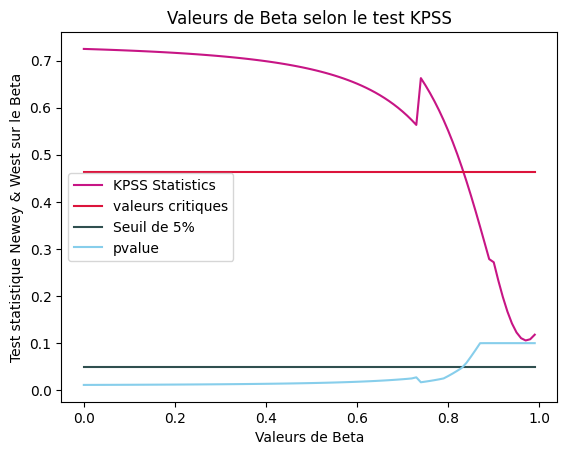

,betax,stat,crit,regression type
0,0.00,0.724815,0.463,c
1,0.01,0.724511,0.463,c
2,0.02,0.724197,0.463,c
3,0.03,0.723875,0.463,c
4,0.04,0.723542,0.463,c
...,...,...,...,...
95,0.95,0.122740,0.463,c
96,0.96,0.110567,0.463,c
97,0.97,0.105710,0.463,c
98,0.98,0.108253,0.463,c


<Figure size 640x480 with 0 Axes>

In [17]:
kpss_beta = newey_west_tests_find_beta(macro, 'KPSS')
kpss_beta

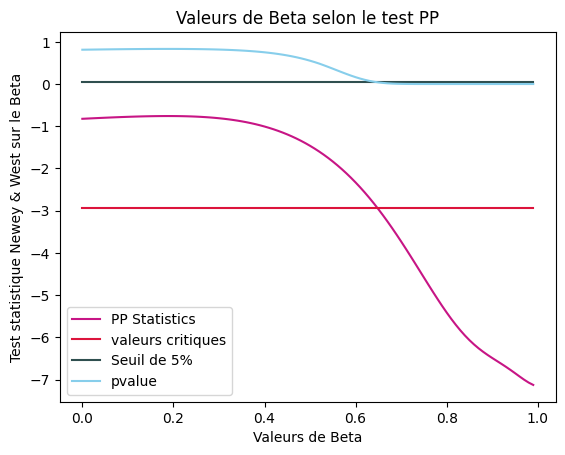

,betax,stat,crit,regression type
0,0.00,-0.823433,-2.941262,c
1,0.01,-0.818126,-2.941262,c
2,0.02,-0.812915,-2.941262,c
3,0.03,-0.807815,-2.941262,c
4,0.04,-0.802840,-2.941262,c
...,...,...,...,...
95,0.95,-6.846128,-2.941262,c
96,0.96,-6.924476,-2.941262,c
97,0.97,-7.000627,-2.941262,c
98,0.98,-7.069329,-2.941262,c


<Figure size 640x480 with 0 Axes>

In [18]:
pp_beta = newey_west_tests_find_beta(macro, 'PP')
pp_beta

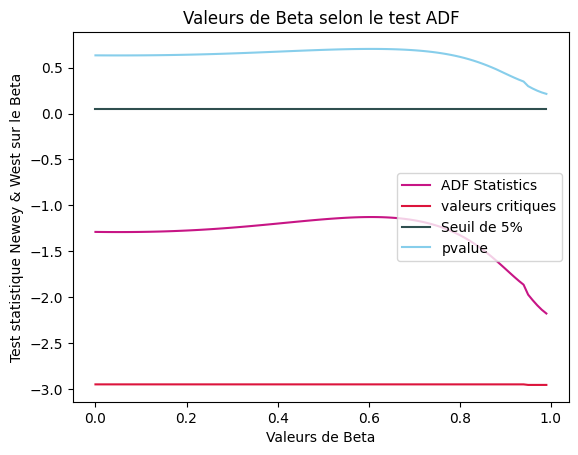

,betax,stat,crit,regression type
0,0.00,-1.290041,-2.951230,c
1,0.01,-1.290618,-2.951230,c
2,0.02,-1.291077,-2.951230,c
3,0.03,-1.291415,-2.951230,c
4,0.04,-1.291627,-2.951230,c
...,...,...,...,...
95,0.95,-1.973643,-2.957219,c
96,0.96,-2.033999,-2.957219,c
97,0.97,-2.089586,-2.957219,c
98,0.98,-2.138483,-2.957219,c


<Figure size 640x480 with 0 Axes>

In [19]:
adf_beta = newey_west_tests_find_beta(macro, 'ADF')
adf_beta

In [21]:
values_adf = np.array(adf_beta[adf_beta['crit'] > adf_beta['stat']]['betax'])
values_kpss = np.array(kpss_beta[kpss_beta['crit'] > kpss_beta['stat']]['betax'])
values_pp = np.array(pp_beta[pp_beta['crit'] > pp_beta['stat']]['betax'])

# Inner join sur les deux arrays : car on veut garder les valeurs de beta pour lesquellesles deux tests expriment la stationnarité
values_available_for_beta = np.intersect1d(values_kpss, values_pp)
print(values_available_for_beta)


[0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


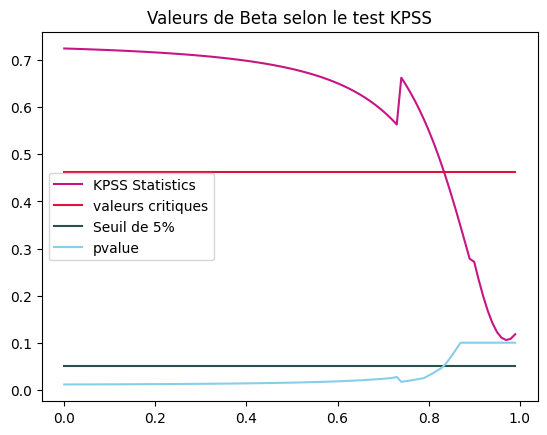

,betax,stat,crit,regression type
0,0.00,0.724815,0.463,c
1,0.01,0.724511,0.463,c
2,0.02,0.724197,0.463,c
3,0.03,0.723875,0.463,c
4,0.04,0.723542,0.463,c
...,...,...,...,...
95,0.95,0.122740,0.463,c
96,0.96,0.110567,0.463,c
97,0.97,0.105710,0.463,c
98,0.98,0.108253,0.463,c


<Figure size 640x480 with 0 Axes>

In [12]:
df_results_kpss = pd.DataFrame(columns=['betax', 'stat', 'crit', 'regression type'])  # create an empty DataFrame with columns for betax, stat, crit, and regression type


for regression in ['c']:
    fig, ax = plt.subplots()
    
    betax = []
    pvalues = []
    crit = []
    stat = []

    for beta in range(100):
        df['DRt_beta'] = df['td'] - (beta/100)*df['td_minus1']
        kpss_result = kpss(df["DRt_beta"], regression=regression)
        stat.append(kpss_result[0])
        pvalues.append(kpss_result[1])
        betax.append(beta/100)
        crit.append(kpss_result[3]['5%']) # récupérer la valeur critique
        df=df.drop('DRt_beta', axis=1)

    # create a new DataFrame for the current regression type
    results_df_kpss = pd.DataFrame({'betax': betax, 'stat': stat, 'crit': crit, 'regression type': [regression] * 100})
    
    # add the results to the main DataFrame
    df_results_kpss = pd.concat([df_results_kpss, results_df_kpss], ignore_index=True)


    ax.plot(betax,stat,color='mediumvioletred' ,label="KPSS Statistics")
    ax.plot(betax,crit, color='crimson', label="valeurs critiques")
    ax.plot(betax,[0.05] * np.shape(crit)[0], color='darkslategrey',label="Seuil de 5%")
    ax.plot(betax,pvalues,color='skyblue', label="pvalue")
    plt.title("Valeurs de Beta selon le test KPSS")

    plt.legend()
    #plt.savefig('graphs/ts_no_season_{}.png'.format(col))
    plt.show()
    plt.figure()

df_results_kpss

### série est stationnaire quand : Pvalue > 5%

In [83]:
#df_results_kpss[df_results_kpss['crit'] > df_results_kpss['stat']]

# PP

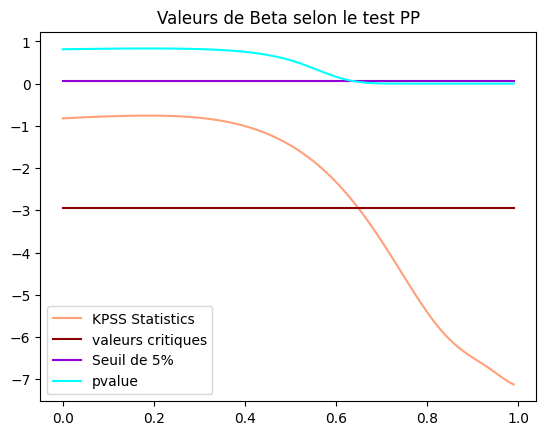

,betax,stat,crit,regression type
0,0.00,-0.823433,-2.941262,c
1,0.01,-0.818126,-2.941262,c
2,0.02,-0.812915,-2.941262,c
3,0.03,-0.807815,-2.941262,c
4,0.04,-0.802840,-2.941262,c
...,...,...,...,...
95,0.95,-6.846128,-2.941262,c
96,0.96,-6.924476,-2.941262,c
97,0.97,-7.000627,-2.941262,c
98,0.98,-7.069329,-2.941262,c


In [84]:
df_results_pp = pd.DataFrame(columns=['betax', 'stat', 'crit', 'regression type'])  # create an empty DataFrame with columns for betax, stat, crit, and regression type
for regression in ['c'] :
    pvalues = []
    betax = []
    crit = []
    stat = []
    for beta in range(100):
        df['DRt_beta'] = df['td'] - (beta/100)*df['td_minus1']
        pp_result = PhillipsPerron(df['DRt_beta'], trend=regression)
        stat.append(pp_result.stat)
        pvalues.append(pp_result.pvalue)
        betax.append(beta/100)
        crit.append(pp_result.critical_values['5%']) # récupérer la valeur critique
        df=df.drop('DRt_beta', axis=1)

    # create a new DataFrame for the current regression type
    results_df_pp = pd.DataFrame({'betax': betax, 'stat': stat, 'crit': crit, 'regression type': [regression] * 100})

    # add the results to the main DataFrame
    df_results_pp = pd.concat([df_results_pp, results_df_pp], ignore_index=True)

    plt.plot(betax,stat,color='lightsalmon' ,label="KPSS Statistics")
    plt.plot(betax,crit, color='darkred', label="valeurs critiques")
    plt.plot(betax,[0.05] * np.shape(crit)[0], color='darkviolet',label="Seuil de 5%")
    plt.plot(betax,pvalues,color='cyan', label="pvalue")

    plt.title("Valeurs de Beta selon le test PP")
    plt.legend()
    #plt.savefig('graphs/ts_no_season_{}.png'.format(col))
    plt.show()

df_results_pp

In [85]:
# stationnaire quand : pvalue<5%

In [86]:
#df_results_pp[df_results_pp['crit'] > df_results_pp['stat']]['betax']

### ADF

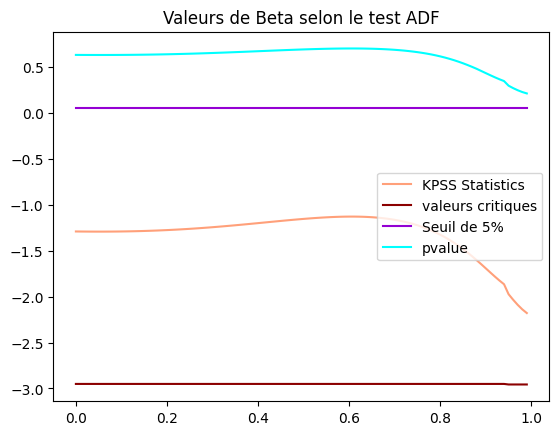

,betax,stat,crit,regression type
0,0.00,-1.290041,-2.951230,c
1,0.01,-1.290618,-2.951230,c
2,0.02,-1.291077,-2.951230,c
3,0.03,-1.291415,-2.951230,c
4,0.04,-1.291627,-2.951230,c
...,...,...,...,...
95,0.95,-1.973643,-2.957219,c
96,0.96,-2.033999,-2.957219,c
97,0.97,-2.089586,-2.957219,c
98,0.98,-2.138483,-2.957219,c


In [24]:
df_results_adf = pd.DataFrame(columns=['betax', 'stat', 'crit', 'regression type'])  # create an empty DataFrame with columns for betax, stat, crit, and regression type
for regression in ['c'] :
    pvalues = []
    betax = []
    crit = []
    stat = []
    for beta in range(100):
        df['DRt_beta'] = df['td'] - (beta/100)*df['td_minus1']
        adf_result = adfuller(df['DRt_beta'], regression=regression)
        stat.append(adf_result[0])
        pvalues.append(adf_result[1])
        betax.append(beta/100)
        crit.append(adf_result[4]['5%']) # récupérer la valeur critique
        df=df.drop('DRt_beta', axis=1)

    # create a new DataFrame for the current regression type
    results_df_adf = pd.DataFrame({'betax': betax, 'stat': stat, 'crit': crit, 'regression type': [regression] * 100})

    # add the results to the main DataFrame
    df_results_adf = pd.concat([df_results_adf, results_df_adf], ignore_index=True)

    plt.plot(betax,stat,color='lightsalmon' ,label="KPSS Statistics")
    plt.plot(betax,crit, color='darkred', label="valeurs critiques")
    plt.plot(betax,[0.05] * np.shape(crit)[0], color='darkviolet',label="Seuil de 5%")
    plt.plot(betax,pvalues,color='cyan', label="pvalue")

    plt.title("Valeurs de Beta selon le test ADF")
    plt.legend()
    #plt.savefig('graphs/ts_no_season_{}.png'.format(col))
    plt.show()

df_results_adf

In [308]:
# Assembler les 3 tests

In [88]:
values_adf = np.array(df_results_adf[df_results_adf['crit'] > df_results_adf['stat']]['betax'])
values_kpss = np.array(df_results_kpss[df_results_kpss['crit'] > df_results_kpss['stat']]['betax'])
values_pp = np.array(df_results_pp[df_results_pp['crit'] > df_results_pp['stat']]['betax'])

In [90]:
# Inner join sur les deux arrays : car on veut garder les valeurs de beta pour lesquellesles deux tests expriment la stationnarité
values_available_for_beta = np.intersect1d(values_kpss, values_pp)
print(values_available_for_beta)


[0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]


In [91]:
# tester les intervalles avec un dataframe, qui ressemble au df avec les sous modèles du BMA

# il faudrait pouvoir choisir de maniere interactive A LA MAIN SUR STREAMLIT l'intervalle des beta qu'on veut

In [92]:
#intervals = [(0, 2), (4, 6)]
intervals = [(0.84, 0.99)]

# Check...
mask = df['Coefficient Beta'].apply(lambda x: any(a <= x <= b for a, b in intervals))

df[mask]

,A,B
1,0.84,5


#  Creation de toutes les varaibles avec les lags, en retire les variables non stationnaires

# ***Corrélation entre les variables macro et le taux de défaut***

On ne peut pas utiliser Pearson à cause du nombre d'observations beaucoup trop faible. Le tau de Kendall est adapté à la taille de l'échantillon en revanche (Approche Non-Parametrique).

#### En calculant des Variables laggées, je crée plusieurs valeurs manquantes en début de séries. Au maximum j'en crée 5. Pour les variables avec les variations annuelles, avec un lag de 5, j'obtiens 10 valeurs manquantes en tout début de période. Je préfère calculer deux lag pour les variables de variations annuelles, ca permet de ne perdre que 6 observations en début de période

In [8]:
Variables_stationnaires = ['HICP_ann', 'HICP_tri', 'IRLT_ann', 'IRLT_tri', 'RGDP_ann', 'RGDP_tri', 'RREP_tri', 'UNR_tri']
macro_var_chosen = macro[Variables_stationnaires+ ['td']]

def compute_var_lagged(macro_corr, nb_lag_var_ann, nb_lag_var_tri):

    for col in macro_corr.filter(regex='_ann').columns:
        # calculer les Lags 
        for lag_number in range(1, nb_lag_var_ann+1):
            macro_corr[col+"_lag"+str(lag_number)] = macro_corr[col].shift(lag_number)

    for col in macro_corr.filter(regex='_tri').columns:
        # calculer les Lags 
        for lag_number in range(1, nb_lag_var_tri+1):
            macro_corr[col+"_lag"+str(lag_number)] = macro_corr[col].shift(lag_number)
    return macro_corr

macro_lagged = compute_var_lagged(macro_var_chosen, 2, 4)
macro_lagged.columns
# macro_lagged = macro_corr.dropna()

Index(['HICP_ann', 'HICP_tri', 'IRLT_ann', 'IRLT_tri', 'RGDP_ann', 'RGDP_tri',
       'RREP_tri', 'UNR_tri', 'td', 'HICP_ann_lag1', 'HICP_ann_lag2',
       'IRLT_ann_lag1', 'IRLT_ann_lag2', 'RGDP_ann_lag1', 'RGDP_ann_lag2',
       'HICP_tri_lag1', 'HICP_tri_lag2', 'HICP_tri_lag3', 'HICP_tri_lag4',
       'IRLT_tri_lag1', 'IRLT_tri_lag2', 'IRLT_tri_lag3', 'IRLT_tri_lag4',
       'RGDP_tri_lag1', 'RGDP_tri_lag2', 'RGDP_tri_lag3', 'RGDP_tri_lag4',
       'RREP_tri_lag1', 'RREP_tri_lag2', 'RREP_tri_lag3', 'RREP_tri_lag4',
       'UNR_tri_lag1', 'UNR_tri_lag2', 'UNR_tri_lag3', 'UNR_tri_lag4'],
      dtype='object')

In [35]:
macro_lagged

,HICP_ann,HICP_tri,IRLT_ann,IRLT_tri,RGDP_ann,RGDP_tri,RREP_tri,UNR_tri,td,HICP_ann_lag1,IRLT_ann_lag1,RGDP_ann_lag1,HICP_tri_lag1,IRLT_tri_lag1,RGDP_tri_lag1,RREP_tri_lag1,UNR_tri_lag1
Date,,,,,,,,,,,,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,NaN,0.011609,NaN,0.002294,NaN,0.005818,0.001510,0.067826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-31,NaN,-0.004170,NaN,-0.061785,NaN,0.003245,-0.006451,0.021849,NaN,NaN,NaN,NaN,0.011609,0.002294,0.005818,0.001510,0.067826
2009-10-31,NaN,0.011061,NaN,-0.004878,NaN,0.002682,-0.015094,0.026107,NaN,NaN,NaN,NaN,-0.004170,-0.061785,0.003245,-0.006451,0.021849
2010-01-31,0.017728,-0.000791,-0.082569,-0.019608,0.019352,0.007475,0.009418,0.013578,0.059661,NaN,NaN,NaN,0.011061,-0.004878,0.002682,-0.015094,0.026107
2010-04-30,0.017524,0.011407,-0.077803,0.007500,0.018300,0.004781,0.007634,-0.023120,0.049995,0.017728,-0.082569,0.019352,-0.000791,-0.019608,0.007475,0.009418,0.013578
2010-07-31,0.019798,-0.001945,-0.073171,-0.057072,0.020576,0.005487,0.000842,-0.004081,0.049434,0.017524,-0.077803,0.018300,0.011407,0.007500,0.004781,0.007634,-0.023120
2010-10-31,0.019581,0.010846,0.159314,0.244737,0.022698,0.004767,-0.005046,-0.045791,0.049466,0.019798,-0.073171,0.020576,-0.001945,-0.057072,0.005487,0.000842,-0.004081
2011-01-31,0.029395,0.008827,0.210000,0.023256,0.015567,0.000450,0.020287,0.004039,0.047990,0.019581,0.159314,0.022698,0.010846,0.244737,0.004767,-0.005046,-0.045791


In [37]:
corr_df = pd.DataFrame(index=macro_lagged.columns, columns=macro_lagged.columns)
macro_lagged = macro_lagged.dropna()
for col1 in macro_lagged.columns:
    for col2 in macro_lagged.columns:
        corr, _ = kendalltau(macro_lagged[col1], macro_lagged[col2])
        corr_df.loc[col1, col2] = corr

# On se focalise sur les correlations concernant le taux de défaut
df_var_corr_to_DR = pd.DataFrame(corr_df['td']).rename(columns={'td': 'Kendall Correlations'}).sort_values(by=['Kendall Correlations']).drop('td',axis=0)
#peu importe le sens des signes, on cherche surtout à avoir les variables qui sont corrélées avec le taux de défaut : donc on prend la valeur absolue
df_var_corr_to_DR['Kendall Correlations'] = df_var_corr_to_DR['Kendall Correlations'].abs()
df_var_corr_to_DR = df_var_corr_to_DR.sort_values(by=['Kendall Correlations'], ascending=False)
df_var_corr_to_DR

,Kendall Correlations
RREP_tri_lag1,0.230769
RREP_tri,0.225371
IRLT_ann_lag1,0.195682
UNR_tri,0.184885
UNR_tri_lag1,0.179487
IRLT_ann,0.160594
RGDP_ann_lag1,0.157895
RGDP_ann,0.109312
IRLT_tri,0.093117
RGDP_tri,0.087719


# On doit pouvoir choisir le seuil de correlation pour garder les variables. On conseille 15% en valeur absolue

In [154]:
def choosing_seuil_corr_to_DR(df, seuil):
    
    """ on choisit le seuil de correlation qu'on veut, puis on crée une liste avec le nom des variables qu'on garde"""
    
    df_var_VERY_corr_to_DR = df[df['Kendall Correlations']>seuil]
    list_var_in_model = df_var_VERY_corr_to_DR.index.tolist()
    return list_var_in_model


list_var_in_model = choosing_seuil_corr_to_DR(df_var_corr_to_DR, 0.15)

In [155]:

sorted(list_var_in_model)


['IRLT_ann',
 'IRLT_ann_lag1',
 'IRLT_ann_lag2',
 'RGDP_ann_lag1',
 'RGDP_ann_lag2',
 'RGDP_tri_lag3',
 'RGDP_tri_lag4',
 'RGDP_tri_lag5',
 'RREP_tri',
 'RREP_tri_lag1',
 'RREP_tri_lag2',
 'RREP_tri_lag3',
 'RREP_tri_lag4',
 'RREP_tri_lag5',
 'UNR_tri',
 'UNR_tri_lag1',
 'UNR_tri_lag3',
 'UNR_tri_lag4',
 'UNR_tri_lag5']

## Correlation des variables(qu'on voudrait garder dans le modèle) : retirer les variables trop corrélées entre elles

<Axes: >

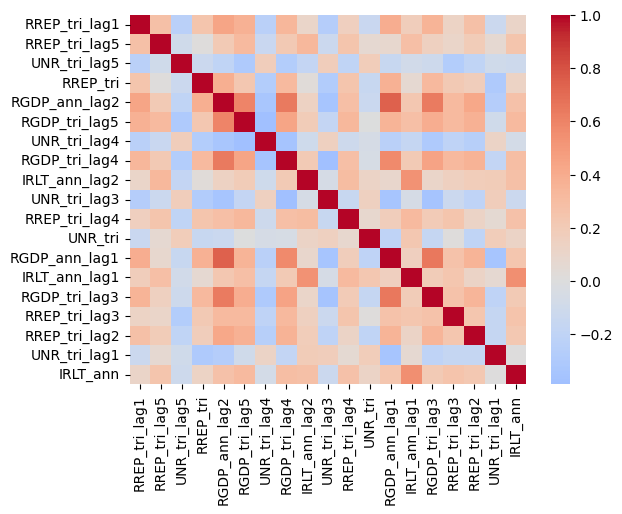

In [161]:
corr_df_macro = pd.DataFrame(index=macro_corr[list_var_in_model].columns, columns=macro_corr[list_var_in_model].columns)

for col1 in macro_corr[list_var_in_model]:
    for col2 in macro_corr[list_var_in_model]:
        corr, _ = kendalltau(macro_corr[list_var_in_model][col1], macro_corr[list_var_in_model][col2])
        corr_df_macro.loc[col1, col2] = corr

# create heatmap
sns.heatmap(corr_df_macro.astype(float), cmap='coolwarm', center=0, annot=False)

In [ ]:
# CHOISIR à la main si on veut retirer des variables ou pas. Perso j'en retire pas
var_a_retirer = []
list_var_in_model = list_var_in_model - var_a_retirer

# UNE AUTRE HISTOIRE... LA MODELISATION

# **Bayesian model average - BMA**
***CHANGER LA FONCTION POUR AVOIR QUE DES MODELES AVEC CONSTANTE***

In [21]:
import itertools
import statsmodels.api as sm

adl = macro_ADL.copy()
df = macro_ADL.copy()
df.head()

,RGDP,HICP,RREP,IRLT,UNR,td
Date,,,,,,
2009-01-31,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-30,0.581847,1.160876,0.151032,0.229358,6.782559,NaN
2009-07-31,0.324505,-0.416953,-0.645107,-6.178490,2.184877,NaN
2009-10-31,0.268196,1.106115,-1.509402,-0.487805,2.610692,NaN
2010-01-31,0.747525,-0.079115,0.941781,-1.960784,1.357811,0.059661


In [ ]:
# calculer les Lags 
df_lags = pd.concat([df.shift(1), df.shift(2), df.shift(3), df.shift(4), df.shift(5)], axis=1)

# Print the original DataFrame and the lagged DataFrame
print(df.columns)
df_lags.columns = ['RGDP_lag1', 'HICP_lag1', 'RREP_lag1', 'IRLT_lag1', 'UNR_lag1', "td_lag1",
                   'RGDP_lag2', 'HICP_lag2', 'RREP_lag2', 'IRLT_lag2', 'UNR_lag2', "td_lag2",
                   'RGDP_lag3', 'HICP_lag3', 'RREP_lag3', 'IRLT_lag3', 'UNR_lag3', "td_lag3",
                   'RGDP_lag4', 'HICP_lag4', 'RREP_lag4', 'IRLT_lag4', 'UNR_lag4', "td_lag4",
                   'RGDP_lag4', 'HICP_lag5', 'RREP_lag5', 'IRLT_lag5', 'UNR_lag5', "td_lag5"]

df_lags[['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'td']] = df[['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'td']]

df_lags = df_lags.dropna()
df_lags.columns

# Je voudrais utiliser toutes ces variables. Mais ggcolab m'en empeche car le BMA prend trop de RAM donc je prends juste l'échantillon de var juste en dessous

In [15]:
# calculer les Lags 
df_lags = pd.concat([df.shift(1), df.shift(2), df.shift(3), df.shift(4), df.shift(5)], axis=1)

# Print the original DataFrame and the lagged DataFrame
print(df.columns)
df_lags.columns = ['RGDP_lag1', 'HICP_lag1', 'RREP_lag1', 'IRLT_lag1', 'UNR_lag1', "td_lag1",
                   'RGDP_lag2', 'HICP_lag2', 'RREP_lag2', 'IRLT_lag2', 'UNR_lag2', "td_lag2",
                   'RGDP_lag3', 'HICP_lag3', 'RREP_lag3', 'IRLT_lag3', 'UNR_lag3', "td_lag3",
                   'RGDP_lag4', 'HICP_lag4', 'RREP_lag4', 'IRLT_lag4', 'UNR_lag4', "td_lag4",
                   'RGDP_lag4', 'HICP_lag5', 'RREP_lag5', 'IRLT_lag5', 'UNR_lag5', "td_lag5"]

df_lags[['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'td']] = df[['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'td']]

df_lags = df_lags.dropna()
df_lags.columns

Index(['RGDP', 'HICP', 'RREP', 'IRLT', 'UNR', 'td'], dtype='object')


Index(['RGDP_lag1', 'HICP_lag1', 'RREP_lag1', 'IRLT_lag1', 'UNR_lag1',
       'td_lag1', 'RGDP_lag2', 'HICP_lag2', 'RREP_lag2', 'IRLT_lag2',
       'UNR_lag2', 'td_lag2', 'RGDP_lag3', 'HICP_lag3', 'RREP_lag3',
       'IRLT_lag3', 'UNR_lag3', 'td_lag3', 'RGDP_lag4', 'HICP_lag4',
       'RREP_lag4', 'IRLT_lag4', 'UNR_lag4', 'td_lag4', 'RGDP_lag4',
       'HICP_lag5', 'RREP_lag5', 'IRLT_lag5', 'UNR_lag5', 'td_lag5', 'RGDP',
       'HICP', 'RREP', 'IRLT', 'UNR', 'td'],
      dtype='object')

In [106]:
# calculer les Lags 
df = df.drop(['RGDP', 'HICP'], axis=1)
df_lags = pd.concat([df.shift(1), df.shift(2), df.shift(3), df.shift(4), df.shift(5)], axis=1)

# Print the original DataFrame and the lagged DataFrame
print(df.columns)
df_lags.columns = ['RREP_lag1', 'IRLT_lag1', 'UNR_lag1', "td_lag1",
                   'RREP_lag2', 'IRLT_lag2', 'UNR_lag2', "td_lag2",
                   'RREP_lag3', 'IRLT_lag3', 'UNR_lag3', "td_lag3",
                   'RREP_lag4', 'IRLT_lag4', 'UNR_lag4', "td_lag4",
                   'RREP_lag5', 'IRLT_lag5', 'UNR_lag5', "td_lag5"]

df_lags[['RREP', 'IRLT', 'UNR', 'td']] = df[['RREP', 'IRLT', 'UNR', 'td']]

df_lags = df_lags.dropna()
df_lags.columns

Index(['RREP', 'IRLT', 'UNR', 'td'], dtype='object')


Index(['RREP_lag1', 'IRLT_lag1', 'UNR_lag1', 'td_lag1', 'RREP_lag2',
       'IRLT_lag2', 'UNR_lag2', 'td_lag2', 'RREP_lag3', 'IRLT_lag3',
       'UNR_lag3', 'td_lag3', 'RREP_lag4', 'IRLT_lag4', 'UNR_lag4', 'td_lag4',
       'RREP_lag5', 'IRLT_lag5', 'UNR_lag5', 'td_lag5', 'RREP', 'IRLT', 'UNR',
       'td'],
      dtype='object')

# BMA - Estimations des équations MCO, vérification des hypothèses, pondération des sous-modèles retenus, calcul de la série DR estimée 

**Estimation de tous les sous-modèles possibles**

In [107]:
# Define the dependent variable and the independent variables (with lags)
y = np.array(df_lags["td"])
X = np.array(df_lags.drop("td", axis=1))

# Create a list of all possible combinations of independent variables
combos = []
for i in range(1, X.shape[1] + 1):
    for combo in itertools.combinations(range(X.shape[1]), i):
        combos.append(combo)


print(len(combos))

8388607


In [13]:
# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv', 'pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5',                           'nb_vars'])

# Loop through all possible combinations of independent variables
rows = []
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    X_combo = X[:, list(combo)]
    X_combo = sm.add_constant(X_combo)
    results = sm.OLS(y, X_combo).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    vif = pd.DataFrame()
    if X_combo.shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X_combo, i) for i in range(1, X_combo.shape[1])]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {f'X_{i}_param': param for i, param in enumerate(results.params)}
    params_dict['const_param'] = params_dict.pop('X_0_param')
    pvals_dict = {f'X_{i}_pval': results.pvalues[i] for i in range(X_combo.shape[1])}
    pvals_dict['const_pval'] = pvals_dict.pop('X_0_pval')
    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': X_combo.shape[1] - 1,
        **params_dict,
        **pvals_dict
    }
    rows.append(row)

# Combine all rows into a single DataFrame
df = pd.concat(rows, ignore_index=True)



KeyboardInterrupt: 

In [ ]:

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov']
for i in range(1, X.shape[1]):
    cols.append(f'X_{i}_param')
    cols.append(f'X_{i}_pval')

df = df[cols]

# Print the DataFrame
df

////


In [ ]:
# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv', 'pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5',
                           'nb_vars'])

# Loop through all possible combinations of independent variables
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    X_combo = X[:, list(combo)]
    X_combo = sm.add_constant(X_combo)
    results = sm.OLS(y, X_combo).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    vif = pd.DataFrame()
    if X_combo.shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X_combo, i) for i in range(1, X_combo.shape[1])]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {f'X_{i}_param': param for i, param in enumerate(results.params)}
    params_dict['const_param'] = params_dict.pop('X_0_param')
    pvals_dict = {f'X_{i}_pval': results.pvalues[i] for i in range(X_combo.shape[1])}
    pvals_dict['const_pval'] = pvals_dict.pop('X_0_pval')
    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': X_combo.shape[1] - 1,
        **params_dict,
        **pvals_dict
    }
    df = df.append(row, ignore_index=True)

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov']
for i in range(1, X.shape[1]):
    cols.append(f'X_{i}_param')
    cols.append(f'X_{i}_pval')

df = df[cols]

# Print the DataFrame
df


In [ ]:
# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv', 'pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5',
                           'nb_vars'])

# Loop through all possible combinations of independent variables
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    X_combo = X[:, list(combo)]
    X_combo = sm.add_constant(X_combo)
    results = sm.OLS(y, X_combo).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    vif = pd.DataFrame()
    if X_combo.shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X_combo, i) for i in range(1, X_combo.shape[1])]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {f'X_{i}_param': param for i, param in enumerate(results.params)}
    params_dict['const_param'] = params_dict.pop('X_0_param')
    pvals_dict = {f'X_{i}_pval': results.pvalues[i] for i in range(X_combo.shape[1])}
    pvals_dict['const_pval'] = pvals_dict.pop('X_0_pval')
    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': X_combo.shape[1] - 1,
        **params_dict,
        **pvals_dict
    }
    df = df.append(row, ignore_index=True)

    # Append the row to the DataFrame
    df = df.append(row, ignore_index=True)

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov']
for i in range(1, X.shape[1]):
    cols.append(f'X_{i}_param')
    cols.append(f'X_{i}_pval')

df = df[cols]

# Print the DataFrame
df


In [16]:
# Define the dependent variable and the independent variables (with lags)
y = df_lags["td"]
X = df_lags.drop("td", axis=1)

# Create a list of all possible combinations of independent variables
combos = []
for i in range(1, len(X.columns) + 1):
    combos.extend(itertools.combinations(X.columns, i))

# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv', 'pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5',
                           'nb_vars'])

MemoryError: 

In [ ]:

# Loop through all possible combinations of independent variables
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    results = sm.OLS(y, sm.add_constant(X[list(combo)])).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    vif = pd.DataFrame()
    if X[list(combo)].shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X[list(combo)].values, i) for i in range(len(combo))]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {var + '_param': param for var, param in zip(results.params.index, results.params)}
    #params_dict.pop("const_param", None) #Je veux garder la constante, et connaitre sa valeur
    pvals_dict = {var + '_pval': results.pvalues[i] for i, var in enumerate(results.params.index)}
    pvals_dict.pop("const_pval", None) # -> peu importe la significativité de la constante, on devra en avoir une dans les modèles, et dans le modele BMA. Ce qui
    # nous intéresse c'est seulement la valeur des constantes
    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': len(combo),
        **params_dict,
        **pvals_dict
    }
    df = df.append(row, ignore_index=True)
    
    row['rsquared'] = results.rsquared
    # Append the row to the DataFrame
    df = df.append(row, ignore_index=True)

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov']
for col in X.columns:
    if col in df.columns:
        cols.append(col + '_param')
        cols.append(col + '_pval')

# Print the DataFrame
df


,variables,bic,logv,pval_shapiro,pval_kolmogorov,mean_resid,nb_var_vif_above_5,nb_vars,RGDP_lag1_param,RGDP_lag1_pval,...,RREP_lag2_param,RREP_lag2_pval,td_lag2_param,td_lag2_pval,RGDP_param,RGDP_pval,HICP_param,HICP_pval,RREP_param,RREP_pval
0,[RGDP_lag1],-244.833489,126.054331,0.013404,4.182594e-09,-1.424299e-17,0,1,-0.005794,0.079773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[RGDP_lag1],-244.833489,126.054331,0.013404,4.182594e-09,-1.424299e-17,0,1,-0.005794,0.079773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[HICP_lag1],-241.967565,124.621369,0.000905,4.132457e-09,1.022574e-17,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[HICP_lag1],-241.967565,124.621369,0.000905,4.132457e-09,1.022574e-17,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[RREP_lag1],-247.163168,127.219170,0.030208,3.976747e-09,-2.081668e-17,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4089,"[RGDP_lag1, RREP_lag1, td_lag1, RGDP_lag2, HIC...",-333.856689,186.935068,0.147501,2.918011e-09,-2.529044e-17,2,10,0.001530,0.279291,...,0.000107,0.835396,0.074152,0.645090,-0.000277,0.503512,0.000820,0.375937,-0.000508,0.267297
4090,"[HICP_lag1, RREP_lag1, td_lag1, RGDP_lag2, HIC...",-332.254719,186.134083,0.093748,2.908627e-09,-9.860533e-18,2,10,NaN,NaN,...,0.000019,0.970857,0.115588,0.471734,-0.000090,0.814541,0.000878,0.354849,-0.000494,0.293839
4091,"[HICP_lag1, RREP_lag1, td_lag1, RGDP_lag2, HIC...",-332.254719,186.134083,0.093748,2.908627e-09,-9.860533e-18,2,10,NaN,NaN,...,0.000019,0.970857,0.115588,0.471734,-0.000090,0.814541,0.000878,0.354849,-0.000494,0.293839
4092,"[RGDP_lag1, HICP_lag1, RREP_lag1, td_lag1, RGD...",-330.239046,186.945040,0.166944,2.920695e-09,-2.081668e-17,2,11,0.001585,0.296765,...,0.000095,0.858622,0.075243,0.647091,-0.000285,0.505207,0.000830,0.381422,-0.000515,0.273858


In [ ]:
"""# Initialize an empty DataFrame to store the results
df = pd.DataFrame(columns=['variables', 'bic', 'logv', 'pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5',                           'nb_vars', 'r_squared'])

# Loop through all possible combinations of independent variables
for combo in combos:
    # Fit an OLS model using the current combination of independent variables
    results = sm.OLS(y, sm.add_constant(X[list(combo)])).fit() #toujours mettre une constante dans le modèle

    # Verify the assumptions of normality and multicollinearity
    resid = results.resid
    p_shapiro = shapiro(resid).pvalue
    p_kolmogorov = kstest(resid, 'norm').pvalue
    vif = pd.DataFrame()
    if X[list(combo)].shape[1] > 1:
        vif['VIF'] = [variance_inflation_factor(X[list(combo)].values, i) for i in range(len(combo))]
        nb_vif_high = (vif['VIF'] > 5).sum()
    else:
        nb_vif_high = 0
        
    # Save the results in the DataFrame
    params_dict = {var + '_param': param for var, param in zip(results.params.index, results.params)}
    params_dict['r_squared'] = results.rsquared # Add R2 to params_dict
    pvals_dict = {var + '_pval': results.pvalues[i] for i, var in enumerate(results.params.index)}
    pvals_dict.pop("const_pval", None) # -> peu importe la significativité de la constante, on devra en avoir une dans les modèles, et dans le modele BMA. Ce qui
    # nous intéresse c'est seulement la valeur des constantes
    row = {
        'variables': list(combo),
        'bic': results.bic,
        'logv': results.llf,
        'pval_shapiro': p_shapiro,
        'pval_kolmogorov': p_kolmogorov,
        'mean_resid': resid.mean(),
        'nb_var_vif_above_5': nb_vif_high,
        'nb_vars': len(combo),
        **params_dict,
        **pvals_dict
    }
    df = df.append(row, ignore_index=True)

# Rearrange the columns of the DataFrame
cols = ['variables', 'nb_vars', 'bic', 'logv', 'mean_resid', 'nb_var_vif_above_5', 'pval_shapiro', 'pval_kolmogorov', 'r_squared']
for col in X.columns:
    if col in df.columns:
        cols.append(col + '_param')
        cols.append(col + '_pval')

# Print the DataFrame
df
"""

'# Initialize an empty DataFrame to store the results\ndf = pd.DataFrame(columns=[\'variables\', \'bic\', \'logv\', \'pval_shapiro\', \'pval_kolmogorov\', \'mean_resid\', \'nb_var_vif_above_5\',                           \'nb_vars\', \'r_squared\'])\n\n# Loop through all possible combinations of independent variables\nfor combo in combos:\n    # Fit an OLS model using the current combination of independent variables\n    results = sm.OLS(y, sm.add_constant(X[list(combo)])).fit() #toujours mettre une constante dans le modèle\n\n    # Verify the assumptions of normality and multicollinearity\n    resid = results.resid\n    p_shapiro = shapiro(resid).pvalue\n    p_kolmogorov = kstest(resid, \'norm\').pvalue\n    vif = pd.DataFrame()\n    if X[list(combo)].shape[1] > 1:\n        vif[\'VIF\'] = [variance_inflation_factor(X[list(combo)].values, i) for i in range(len(combo))]\n        nb_vif_high = (vif[\'VIF\'] > 5).sum()\n    else:\n        nb_vif_high = 0\n        \n    # Save the results 

**Etude des hypothèses**

In [ ]:
df_bma = df.copy()

In [ ]:
df_bma[['pval_shapiro', 'pval_kolmogorov', 'mean_resid']] = df_bma[['pval_shapiro', 'pval_kolmogorov', 'mean_resid']].round(4)

In [ ]:
df_bma.mean_resid.describe()

count    4094.0
mean        0.0
std         0.0
min        -0.0
25%         0.0
50%        -0.0
75%         0.0
max        -0.0
Name: mean_resid, dtype: float64

Tous les modèles ont des résidus très proches de 0 en moyenne

In [ ]:
df_bma.pval_shapiro.describe()

count    4094.000000
mean        0.234468
std         0.243191
min         0.000200
25%         0.052850
50%         0.138300
75%         0.318225
max         0.973900
Name: pval_shapiro, dtype: float64

When pvalue>5% : then we fail to reject the null hypothesis i.e. we do not have sufficient evidence to say that sample does not come from a normal distribution.

Ici on a à peu près 75% des modèles qui ont une pval supérieure à 5%. On peut décider de mettre de côté les modèles avec une pval < 5% et n'utiliser que les autres



In [ ]:
df_bma.pval_kolmogorov.describe()

count    4094.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: pval_kolmogorov, dtype: float64

The p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data are not distributed according to the standard normal.

BUT
K-S a l'air très difficile à respecter : aucun modèle ne passe le tests. Le test a l'air trop restrictif

(array([3058.,    0.,    0.,    0.,    0.,   12.,    0.,    0.,    0.,
        1024.]),
 array([0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002,
        1.4000000000000001, 1.6, 1.8, 2.0], dtype=object),
 <BarContainer object of 10 artists>)

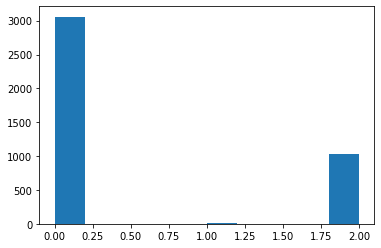

In [ ]:
plt.hist(df_bma.nb_var_vif_above_5)

On peut décider ici de retirer tous les modèles avec des VIF > 5

En appliquant les deux règles (shapiro et VIF) alors on perd la moitié des sous-modèles. Ceci signifie que la moitié des sous-modèles ne respectent pas les hypothèses de normalité des résidus et de non-multi-collinéarité des variables

In [ ]:
df_models_kept = df_bma[(df_bma.nb_var_vif_above_5 < 1 ) & (df_bma.pval_shapiro > 0.05)]
df_models_kept = df_models_kept.drop(['pval_shapiro', 'pval_kolmogorov', 'mean_resid', 'nb_var_vif_above_5'], axis=1)

In [ ]:
np.shape(df_models_kept)

(2310, 28)

  Maintenant je garde les modèles qui respectent les hypothèses sur les pvalues des variables 

In [ ]:
#ici je regarde juste l'occurence des variables, des sous modèles non colinéaires et aux résidus normaux

pval_cols = [col for col in df_models_kept.columns if col.endswith('_param')]

for col in pval_cols :

  print(col , ": Nombre de modèles sans cette variables :" , df_models_kept[col].isna().sum())

RGDP_lag1_param : Nombre de modèles sans cette variables : 1126
const_param : Nombre de modèles sans cette variables : 0
HICP_lag1_param : Nombre de modèles sans cette variables : 1110
RREP_lag1_param : Nombre de modèles sans cette variables : 1066
td_lag1_param : Nombre de modèles sans cette variables : 1454
RGDP_lag2_param : Nombre de modèles sans cette variables : 1162
HICP_lag2_param : Nombre de modèles sans cette variables : 1134
RREP_lag2_param : Nombre de modèles sans cette variables : 1058
td_lag2_param : Nombre de modèles sans cette variables : 1288
RGDP_param : Nombre de modèles sans cette variables : 1122
HICP_param : Nombre de modèles sans cette variables : 1084
RREP_param : Nombre de modèles sans cette variables : 1182


In [ ]:
# ici je regarde plus sérieusement la significativité des variables, et je drop tous les sous modèles avec des pvalues 
pval_cols = [col for col in df_models_kept.columns if col.endswith('_pval')]

for col in pval_cols :
    df_models_kept[col] = df_models_kept[col].fillna(-100) # ca facilite le mask juste après.

mask = (df_models_kept[pval_cols] < 0.05).all(axis=1)

df_significant = df_models_kept[mask]


In [ ]:
df_significant

,variables,bic,logv,nb_vars,RGDP_lag1_param,RGDP_lag1_pval,const_param,rsquared,HICP_lag1_param,HICP_lag1_pval,...,RREP_lag2_param,RREP_lag2_pval,td_lag2_param,td_lag2_pval,RGDP_param,RGDP_pval,HICP_param,HICP_pval,RREP_param,RREP_pval
6,[td_lag1],-348.008128,177.641650,1,NaN,-100.0,0.000543,NaN,NaN,-100.0,...,NaN,-100.000000,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.00000
7,[td_lag1],-348.008128,177.641650,1,NaN,-100.0,0.000543,0.939285,NaN,-100.0,...,NaN,-100.000000,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.00000
14,[td_lag2],-319.086056,163.180614,1,NaN,-100.0,0.002826,NaN,NaN,-100.0,...,NaN,-100.000000,0.896287,1.579076e-17,NaN,-100.0,NaN,-100.0,NaN,-100.00000
15,[td_lag2],-319.086056,163.180614,1,NaN,-100.0,0.002826,0.870031,NaN,-100.0,...,NaN,-100.000000,0.896287,1.579076e-17,NaN,-100.0,NaN,-100.0,NaN,-100.00000
60,"[RREP_lag1, td_lag1]",-351.869248,181.391003,2,NaN,-100.0,0.001267,NaN,NaN,-100.0,...,NaN,-100.000000,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.00000
61,"[RREP_lag1, td_lag1]",-351.869248,181.391003,2,NaN,-100.0,0.001267,0.950158,NaN,-100.0,...,NaN,-100.000000,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.00000
68,"[RREP_lag1, td_lag2]",-327.883936,169.398347,2,NaN,-100.0,0.003454,NaN,NaN,-100.0,...,NaN,-100.000000,0.859482,1.898194e-18,NaN,-100.0,NaN,-100.0,NaN,-100.00000
69,"[RREP_lag1, td_lag2]",-327.883936,169.398347,2,NaN,-100.0,0.003454,0.906305,NaN,-100.0,...,NaN,-100.000000,0.859482,1.898194e-18,NaN,-100.0,NaN,-100.0,NaN,-100.00000
112,"[RREP_lag2, td_lag2]",-319.996794,165.454776,2,NaN,-100.0,0.003195,NaN,NaN,-100.0,...,-0.001135,0.042119,0.874949,2.464741e-17,NaN,-100.0,NaN,-100.0,NaN,-100.00000
113,"[RREP_lag2, td_lag2]",-319.996794,165.454776,2,NaN,-100.0,0.003195,0.884693,NaN,-100.0,...,-0.001135,0.042119,0.874949,2.464741e-17,NaN,-100.0,NaN,-100.0,NaN,-100.00000


Maintenant que je n'ai gardé que les modèles qui respectent les hypothèses, je peux regarder quels modèles sont les plus performants : Avec le BIC je calcule la proba à posteriori. 

**Sélection des sous-modèles les plus performants et Proba à posteriori**

In [ ]:
df_sorted = df_significant.sort_values(by=['bic']) 
n = len(df_sorted) // 2 
df_filtered = df_sorted.head(n)
df_filtered


,variables,bic,logv,nb_vars,RGDP_lag1_param,RGDP_lag1_pval,const_param,rsquared,HICP_lag1_param,HICP_lag1_pval,...,td_lag2_param,td_lag2_pval,RGDP_param,RGDP_pval,HICP_param,HICP_pval,RREP_param,RREP_pval,prob_post_num,prob_posteriori
296,"[RREP_lag1, td_lag1, HICP_lag2]",-352.918342,183.734343,3,NaN,-100.0,0.001012,NaN,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,4.317618e+76,0.298030
297,"[RREP_lag1, td_lag1, HICP_lag2]",-352.918342,183.734343,3,NaN,-100.0,0.001012,0.955942,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,4.317618e+76,0.298030
60,"[RREP_lag1, td_lag1]",-351.869248,181.391003,2,NaN,-100.0,0.001267,NaN,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,2.555268e+76,0.176381
61,"[RREP_lag1, td_lag1]",-351.869248,181.391003,2,NaN,-100.0,0.001267,0.950158,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,2.555268e+76,0.176381
6,[td_lag1],-348.008128,177.641650,1,NaN,-100.0,0.000543,NaN,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,3.706848e+75,0.025587
7,[td_lag1],-348.008128,177.641650,1,NaN,-100.0,0.000543,0.939285,NaN,-100.0,...,NaN,-1.000000e+02,NaN,-100.0,NaN,-100.0,NaN,-100.0,3.706848e+75,0.025587
68,"[RREP_lag1, td_lag2]",-327.883936,169.398347,2,NaN,-100.0,0.003454,NaN,NaN,-100.0,...,0.859482,1.898194e-18,NaN,-100.0,NaN,-100.0,NaN,-100.0,1.581583e+71,0.000001


In [ ]:
# c'est équivalent au fait d'appliquer le SoftMax sur la colonne du BIC
df_filtered['prob_post_num'] = df_filtered['bic'].apply(lambda x: np.exp(-0.5 * x))
df_filtered['prob_posteriori'] = df_filtered['prob_post_num'].apply(lambda x: x/df_filtered['prob_post_num'].sum())

<ipython-input-78-860c4e2d7924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['prob_post_num'] = df_filtered['bic'].apply(lambda x: np.exp(-0.5 * x))
<ipython-input-78-860c4e2d7924>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['prob_posteriori'] = df_filtered['prob_post_num'].apply(lambda x: x/df_filtered['prob_post_num'].sum())


**Pondération des sous-modèles, contruction finale du modèle BMA et analyse des résultats de la modélisation**

In [ ]:

### Création du dataframe avec les colonnes que l'on garde car au moins un modèle admet un coefficient pour la variable & aussi on applique la pondération des coefficients par la probabilité a posteriori du modele. On fillna par 0 les colonnes vides
# filter out the columns that end with '_param'
param_cols = [col for col in df_filtered.columns if col.endswith('_param')]

# create a new dataframe with the filtered columns multiplied by 'prob_posteriori'
df_significant_param = df_filtered[param_cols].multiply(df_filtered['prob_posteriori'], axis=0)

# print the new dataframe
df_significant_param = df_significant_param.fillna(0)

### On drop les colonnes sans coefficients ; ce sont des variables non significatives ou qui n'expliquent pas la target.
# create a list of columns to drop
cols_to_drop = []

# loop through each column in the DataFrame
for col in df_significant_param.columns:
    # check if the column is filled with 0
    if df_significant_param[col].eq(0).all():
        cols_to_drop.append(col)

# drop the columns that are filled with 0
df_significant_param_no_0 = df_significant_param.drop(cols_to_drop, axis=1)

### Finalement on va sommer les colonnes, ca fait qu'on obtient dans chaque colonne le paramètre de la variable associée
# sum all the columns of the DataFrame
df_sum = df_significant_param_no_0.sum()

# convert the resulting series to a DataFrame with one row
df_row_parameters = pd.DataFrame(df_sum).transpose()

# Create a dictionary of old and new column names
rename_dict = {col: col.replace('_param', '') for col in df_row_parameters.columns}

# Rename the columns using the dictionary
df_row_parameters = df_row_parameters.rename(columns=rename_dict)

### Il faut utiliser les paramètres et les observations pour créer la série DRt estimée
#maintenant qu'on a les coefficients il faut les utiliser avec les observations pour calculer le DRt Estimé 
df_X = X.copy()

# Get the column names of df_X and df_row_parameters
X_cols = set(df_X.columns)
params_cols = set(df_row_parameters.columns)
#Attention : on perd la constance ici, ON DOIT LA RAJOUTER ENSUITE

# Find the common columns between the two sets
common_cols = list(X_cols.intersection(params_cols))

# Create a new DataFrame with only the common columns
df_X_common = df_X[common_cols]

# Convert the DataFrames to numpy arrays
X_observed = df_X_common.values
params = df_row_parameters[common_cols].values.reshape(-1, 1)

# Multiply X and params using matrix multiplication
pred_values = X_observed @ params 

# Adding the intercept...
pred_values_BMA = pred_values + df_row_parameters.const[0]


In [ ]:
df_pred = pd.DataFrame(pred_values_BMA, index=df_X.index, columns=['pred_values_BMA'])
y_obs = pd.DataFrame(y)
df_actual_and_predict = pd.merge(df_pred, y_obs, how='inner', left_index=True, right_index=True)


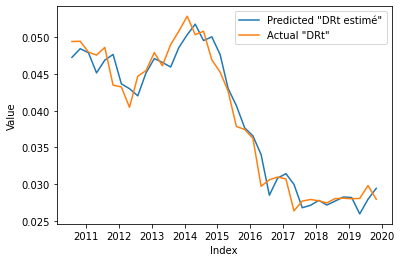

In [ ]:
x = df_actual_and_predict.index # Use the index as the x-axis
y_pred = df_actual_and_predict['pred_values_BMA'] # Get the predicted values
y_actual = df_actual_and_predict['td'] # Get the actual values

# Plot the predicted values and actual values as two separate lines
plt.plot(x, y_pred, label='Predicted "DRt estimé"')
plt.plot(x, y_actual, label='Actual "DRt"')

# Set the axis labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()


In [ ]:
coefficient_of_dermination_BMA = round(r2_score(y, pred_values_BMA), 4)
coefficient_of_dermination_BMA

0.955

In [ ]:
mean_squared_error_BMA = round(mean_squared_error(y, pred_values_BMA, squared=False), 4)
mean_squared_error_BMA

0.0019

# Sans pondération : garder le meilleur modèle

Le modèle qui minimise le critère d'info <=> BIC

In [ ]:
row_with_lowest_bic = pd.DataFrame(df_significant.loc[df_significant['bic'].idxmin()]).T

row_with_lowest_bic

,variables,bic,logv,nb_vars,RGDP_lag1_param,RGDP_lag1_pval,const_param,rsquared,HICP_lag1_param,HICP_lag1_pval,...,td_lag2_param,td_lag2_pval,RGDP_param,RGDP_pval,HICP_param,HICP_pval,RREP_param,RREP_pval,prob_post_num,prob_posteriori
296,"[RREP_lag1, td_lag1, HICP_lag2]",-352.918342,183.734343,3,NaN,-100.0,0.001012,NaN,NaN,-100.0,...,NaN,-100.0,NaN,-100.0,NaN,-100.0,NaN,-100.0,4317617727089839393897149523187017377534173351...,0.29803


In [ ]:
def compute_y_estimated_from_model(df):

  # filter out the columns that end with '_param'
  param_cols = [col for col in df.columns if col.endswith('_param')]
  df = df[param_cols]
  # print the new dataframe
  df_significant_param = df.fillna(0)

  # create a list of columns to drop
  cols_to_drop = []

  # loop through each column in the DataFrame
  for col in df_significant_param.columns:
    # check if the column is filled with 0
    if df_significant_param[col].eq(0).all():
        cols_to_drop.append(col)
  df_row_parameters = df_significant_param.drop(cols_to_drop, axis=1)

  
  # Create a dictionary of old and new column names
  rename_dict = {col: col.replace('_param', '') for col in df_row_parameters.columns}

  # Rename the columns using the dictionary
  df_row_parameters = df_row_parameters.rename(columns=rename_dict)

  ### Il faut utiliser les paramètres et les observations pour créer la série DRt estimée
  #maintenant qu'on a les coefficients il faut les utiliser avec les observations pour calculer le DRt Estimé 
  df_X = X.copy()

  # Get the column names of df_X and df_row_parameters
  X_cols = set(df_X.columns)
  params_cols = set(df_row_parameters.columns)

  # Find the common columns between the two sets
  common_cols = list(X_cols.intersection(params_cols))

  # Create a new DataFrame with only the common columns
  df_X_common = df_X[common_cols]

  # Convert the DataFrames to numpy arrays
  X_observed = df_X_common.values
  params = df_row_parameters[common_cols].values.reshape(-1, 1)

  # Multiply X and params using matrix multiplication
  pred_values = X_observed @ params 
  
  df_row_parameters.reset_index(drop=True, inplace=True)

  # Adding the intercept...
  pred_values_model = pred_values + df_row_parameters.const[0]

  return pred_values_model

pred_values_model_bic = compute_y_estimated_from_model(row_with_lowest_bic)

In [ ]:
coefficient_of_dermination_best_bic = round(r2_score(y, pred_values_model_bic), 4)
coefficient_of_dermination_best_bic

0.9559

In [ ]:
mean_squared_error_best_bic = round(mean_squared_error(y, pred_values_model_bic, squared=False), 4)
mean_squared_error_best_bic

0.0019

**Le modèle qui maximise la vraisemblance**

In [ ]:
row_with_highest_LL = pd.DataFrame(df_significant.loc[df_significant['logv'].idxmax()]).T
row_with_highest_LL

,variables,bic,logv,nb_vars,RGDP_lag1_param,RGDP_lag1_pval,const_param,rsquared,HICP_lag1_param,HICP_lag1_pval,...,td_lag2_param,td_lag2_pval,RGDP_param,RGDP_pval,HICP_param,HICP_pval,RREP_param,RREP_pval,prob_post_num,prob_posteriori
296,"[RREP_lag1, td_lag1, HICP_lag2]",-352.918342,183.734343,3,NaN,-100.0,0.001012,NaN,NaN,-100.0,...,NaN,-100.0,NaN,-100.0,NaN,-100.0,NaN,-100.0,4317617727089839393897149523187017377534173351...,0.29803


In [ ]:
pred_values_model_LL = compute_y_estimated_from_model(row_with_highest_LL)

In [ ]:
coefficient_of_dermination_best_bic = round(r2_score(y, pred_values_model_LL), 4)
coefficient_of_dermination_best_bic

0.9559

In [ ]:
mean_squared_error_best_LL = round(mean_squared_error(y, pred_values_model_LL, squared=False), 4)
mean_squared_error_best_LL

0.0019